In [1]:
import math
import numpy as np

from tqdm import tqdm
from glob import glob

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts

# 시각화
from scipy.interpolate import griddata
import seaborn as sns
import matplotlib.pyplot as plt

# Network
from net.network import MultiScaleMLPSequential

In [2]:
# CUDA check
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 1


In [32]:
def compute_derivatives(model, xy_data):
    """
    Get fxx, fyy
    """
    xy_data = xy_data.to(device)
    # Ensure that xy_data has gradient information.
    xy_data.requires_grad_(True)
    
    # Get the model prediction.
    f_pred = model(xy_data)
    
    # Create a tensor of ones with the same shape as f_pred to be used for gradient computation.
    # Reshape the ones tensor to match the shape of f_pred.
    ones = torch.ones(f_pred.shape, device=device, requires_grad=False)
    
    # Compute the first derivatives.
    f_x = torch.autograd.grad(f_pred, xy_data, grad_outputs=ones, create_graph=True)[0][:, 0]
    f_y = torch.autograd.grad(f_pred, xy_data, grad_outputs=ones, create_graph=True)[0][:, 1]
    
    # Compute the second derivatives.
    f_xx = torch.autograd.grad(f_x, xy_data, grad_outputs=ones[:, 0], create_graph=True)[0][:, 0]
    f_yy = torch.autograd.grad(f_y, xy_data, grad_outputs=ones[:, 0], create_graph=True)[0][:, 1]
    
    return f_xx, f_yy

def multiscale_task_loss(model, criterion, xy_daya, f_data, B, C, alpha=0.1):
    """
    추가 도입 예정
    """
    pass


def create_dataloader(data, batch_size, shuffle=True):
    """
    get dataloader
    """
    xy_data = torch.tensor(np.stack([data.T[0], data.T[1]], axis=-1), dtype=torch.float)
    f_data = torch.tensor(data.T[2], dtype=torch.float).view(-1, 1)
    a_data = torch.tensor(data.T[3], dtype=torch.float).view(-1, 1)
    b_data = torch.tensor(data.T[4], dtype=torch.float).view(-1, 1)
    c_data = torch.tensor(data.T[5], dtype=torch.float).view(-1, 1)
    
    dataset = TensorDataset(xy_data, f_data, a_data, b_data, c_data)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return tqdm(loader, desc="Training ", leave=False)


def train_model(model, loader, epochs):
    """
    Implementation func of model training
    """
    
    for epoch in range(epochs):
        model.train()
        batch_loss = 0.0
        batch_data_loss = 0.0  # To record data loss
        batch_pde_loss = 0.0   # To record pde loss
        batch_l1_loss = 0.0

        for batch_xy, batch_f, batch_a, batch_b, batch_c in loader:
            batch_xy = batch_xy.to(device)
            batch_f  = batch_f.to(device)
            batch_a  = batch_a.to(device)
            batch_b  = batch_b.to(device)
            batch_c  = batch_c.to(device)
            
            optimizer.zero_grad()

            # Calculate the losses
            f_pred = model(batch_xy)
            data_loss = criterion(f_pred, batch_f)
            f_xx, f_yy = compute_derivatives(model, batch_xy)
            true_pde = -(batch_b**2+batch_c**2)*f_pred
            pde_loss = alpha * criterion(f_xx + f_yy, true_pde.squeeze())
            l1_loss = l1_regularization(model, lambda_l1=0.01)
            # Combine the losses
            loss = data_loss + pde_loss + l1_loss

            # Backpropagate and optimize
            loss.backward()
            optimizer.step()

            # Record losses
            batch_loss += loss.item()
            batch_data_loss += data_loss.item()
            batch_pde_loss += pde_loss.item()
            batch_l1_loss += l1_loss

        avg_loss = batch_loss / len(loader)
        avg_data_loss = batch_data_loss / len(loader)
        avg_pde_loss = batch_pde_loss / len(loader)
        avg_l1_loss = batch_l1_loss / len(loader)

        # Append the average losses for this epoch to the history
        loss_history.append(avg_loss)
        data_loss_history.append(avg_data_loss)
        pde_loss_history.append(avg_pde_loss)
        l1_loss_history.append(avg_l1_loss)

        scheduler.step() # ReduceLROnPlateau 이면 Loss를 인자로 넣어야함

        # Print the losses every 100 epochs
        if epoch % 10 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f'Epoch {epoch}/{epochs}')
            print(f'Data Loss: {avg_data_loss}, PDE Loss: {avg_pde_loss}, L1_Loss: {avg_l1_loss}')
            print(f"Total Loss: {avg_loss}, LR: {current_lr}")

    # 손실값 그래프를 그립니다.
    print("total loss : ",loss_history[-1])
    print("DATA  loss : ",data_loss_history[-1])
    print("PDE   loss : ",pde_loss_history[-1])
    plt.semilogy(loss_history, label="Total")
    plt.semilogy(data_loss_history, label="Data")
    plt.semilogy(pde_loss_history, label="PDE")
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title('Epoch vs loss')
    plt.legend()
    plt.show()

def test_inference(model, data):
    x = data.T[0]
    y = data.T[1]
    X = data[:,:2]
    f_true = data.T[2]

    X = torch.tensor(X, dtype=torch.float)
    X = X.to(device)
    print(f"Task :: A={data.T[3][0]}, B={data.T[4][0]}, C={data.T[5][0]}")
    with torch.no_grad():
        f_pred = model(X).cpu().numpy().squeeze()

    loss = np.mean(np.sqrt(np.abs(np.square(f_true.reshape(-1))-np.square(f_pred.reshape(-1)))))
    print("Test MSE Loss : ", loss)

    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(7,3))
    # grid
    grid_x, grid_y = np.mgrid[x.min():x.max():500j, y.min():y.max():500j]

    # f_true figure
    grid_f = griddata(X.cpu().numpy(), f_true, (grid_x, grid_y), method='cubic')
    img = ax[0].imshow(grid_f, origin='lower',extent=[x.min(), x.max(), y.min(), y.max()], cmap='viridis')
    ax[0].set(xlabel='X', ylabel='Y')
    fig.colorbar(img,shrink=0.9)

    # f_pred figure
    grid_f = griddata(X.cpu().numpy(), f_pred, (grid_x, grid_y), method='cubic')
    img = ax[1].imshow(grid_f, origin='lower',extent=[x.min(), x.max(), y.min(), y.max()], cmap='viridis')
    ax[1].set(xlabel='X', ylabel='Y')
    fig.colorbar(img,shrink=0.9)
    plt.show()
    return loss

# L1 규제 적용
def l1_regularization(model, lambda_l1):
    l1_loss = 0
    for param in model.parameters():
        l1_loss += torch.sum(torch.abs(param))
    return lambda_l1 * l1_loss

In [13]:
# 하이퍼 파라미터
batch_size = 100000
shuffle = True # 데이터 셔플
epochs = 2000   # 훈련 epoch
alpha= 0.001      # Total Loss = Data Loss + alpha * PDE Loss

In [14]:
# Data load
with open("./data/train_sampling.npy", 'rb') as f:
    data = np.load(f,allow_pickle=True)
f.close()

# Sample data
print(data.shape) #100000 of [x, y, f(x,y), A, B, C]

(500000, 6)


In [7]:
loader = create_dataloader(data, batch_size, shuffle)

model = MultiScaleMLPSequential(
    in_dim=2,
    out_dim=1,
    layers=7,
    neurons=32,
    residual=True,
    subnets=2,
    base_scale=1.1,
    in_scale= [2*np.pi,2*np.pi],
    in_center=[0, 0],
    vec_scen=2,
    vec_size=12,
)
model = model.to(device)
# loss
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=20, verbose=False)
scheduler = CosineAnnealingWarmRestarts(optimizer, 2000, T_mult=1, eta_min=0.0002)

# init
loss_history = []
data_loss_history = []
pde_loss_history = []
l1_loss_history = []

best_loss = float('inf')

Training :   0%|          | 0/5 [00:00<?, ?it/s]

Train start



Epoch 0/2000
Data Loss: 2.1707589626312256, PDE Loss: 0.0011514461366459727, L1_Loss: 6.679286479949951
Total Loss: 8.851197052001954, LR: 0.019999987786367066
Epoch 10/2000
Data Loss: 2.1274330615997314, PDE Loss: 2.0069238502173902e-07, L1_Loss: 0.33814042806625366
Total Loss: 2.4655736446380616, LR: 0.019998522186878982
Epoch 20/2000
Data Loss: 2.1274359703063963, PDE Loss: 2.2812335309652098e-08, L1_Loss: 0.2899647355079651
Total Loss: 2.4174006938934327, LR: 0.01999461427515605
Epoch 30/2000
Data Loss: 2.127430629730225, PDE Loss: 1.1605934986391731e-07, L1_Loss: 0.28891053795814514
Total Loss: 2.4163413047790527, LR: 0.01998826501541702
Epoch 40/2000
Data Loss: 2.127450704574585, PDE Loss: 2.55462922993388e-07, L1_Loss: 0.28827935457229614
Total Loss: 2.415730333328247, LR: 0.019979475974246718
Epoch 50/2000
Data Loss: 2.1274421215057373, PDE Loss: 1.064766131264605e-07, L1_Loss: 0.29133057594299316
Total Loss: 2.418772792816162, LR: 0.019968249320209543
Epoch 60/2000
Data Loss: 

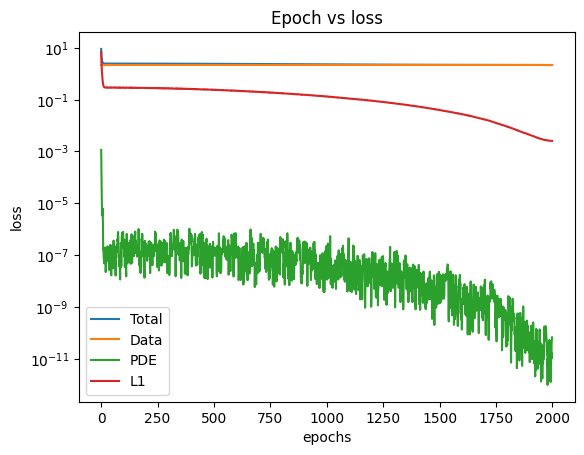

Train end



In [21]:
#### 훈련 시작 ####
print("Train start\n")
train_model(model, loader, epochs)
print("Train end\n")

In [22]:
torch.save(model.state_dict(), "./data/MAD_model.pt")

# Interpolation test

## load data

In [18]:
inter_tasks_path = glob("./data/inter_sampling.npy")
with open(inter_tasks_path[0], 'rb') as f:
    data = np.load(f,allow_pickle=True)
inter_tasks = np.split(data, 5)

## sample

Task :: A=5.093690735623753, B=1.2287257784195504, C=1.5810637532866647
Test MSE Loss :  1.953865547882217


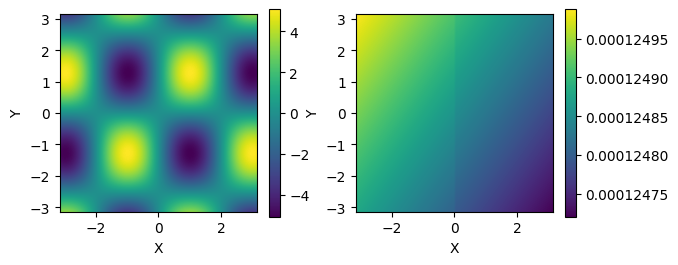

Task :: A=4.487807434590005, B=1.543674181647733, C=1.0813534333913433
Test MSE Loss :  1.7370305089899445


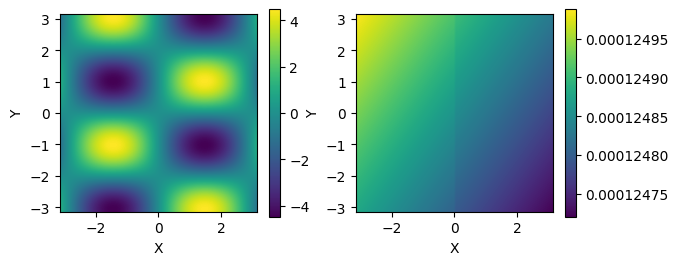

Task :: A=2.777942819756045, B=1.7213625675027244, C=1.216882697534249
Test MSE Loss :  1.0903597285225106


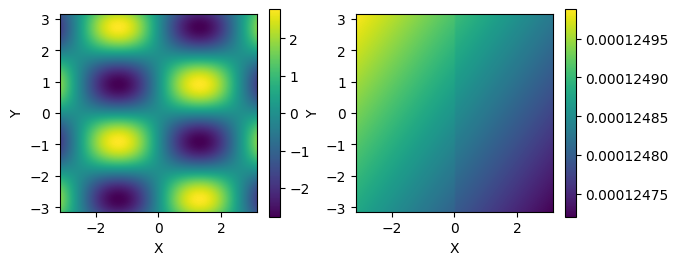

Task :: A=9.374984508659168, B=0.6460623338874734, C=1.9654454951206688
Test MSE Loss :  4.2866672738204885


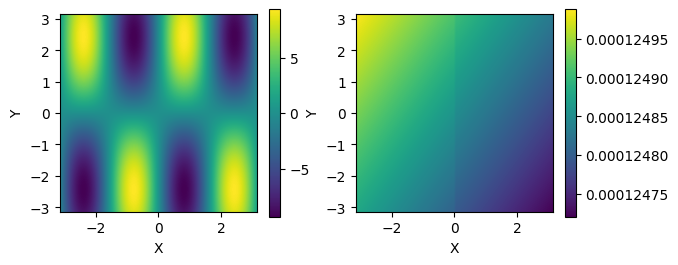

Task :: A=7.688984649286316, B=1.0310431618538227, C=0.5454349450272911
Test MSE Loss :  3.1623071945273593


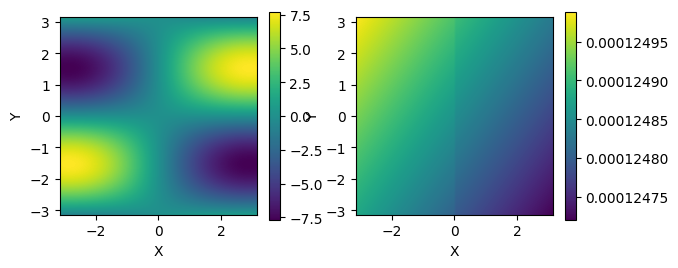

In [33]:
model = MultiScaleMLPSequential(
    in_dim=2,
    out_dim=1,
    layers=7,
    neurons=32,
    residual=True,
    subnets=2,
    base_scale=1.1,
    in_scale= [2*np.pi,2*np.pi],
    in_center=[0, 0],
    vec_scen=2,
    vec_size=12,
)
model.load_state_dict(torch.load(f"./data/MAD_model.pt"))
model = model.to(device)
for inter_task in inter_tasks:
    test_inference(model, inter_task)

## Helper function

In [70]:
def transfer_model(model, data, epochs, save_title=""):
    """
    Implementation func of model training
    """
    loader = create_dataloader(data, batch_size, shuffle)
    
    for epoch in range(epochs):
        model.train()
        batch_loss = 0.0
        batch_data_loss = 0.0  # To record data loss
        batch_pde_loss = 0.0   # To record pde loss
        batch_l1_loss = 0.0

        for batch_xy, batch_f, batch_a, batch_b, batch_c in loader:
            batch_xy = batch_xy.to(device)
            batch_f  = batch_f.to(device)
            batch_a  = batch_a.to(device)
            batch_b  = batch_b.to(device)
            batch_c  = batch_c.to(device)
            
            optimizer.zero_grad()

            # Calculate the losses
            f_pred = model(batch_xy)
            data_loss = criterion(f_pred, batch_f)
            f_xx, f_yy = compute_derivatives(model, batch_xy)
            true_pde = -(batch_b**2+batch_c**2)*f_pred
            pde_loss = alpha * criterion(f_xx + f_yy, true_pde.squeeze())
            # Combine the losses
            loss = data_loss + pde_loss

            # Backpropagate and optimize
            loss.backward()
            optimizer.step()

            # Record losses
            batch_loss += loss.item()
            batch_data_loss += data_loss.item()
            batch_pde_loss += pde_loss.item()


        avg_loss = batch_loss / len(loader)
        avg_data_loss = batch_data_loss / len(loader)
        avg_pde_loss = batch_pde_loss / len(loader)

        # Append the average losses for this epoch to the history
        loss_history.append(avg_loss)
        data_loss_history.append(avg_data_loss)
        pde_loss_history.append(avg_pde_loss)

        scheduler.step() # ReduceLROnPlateau 이면 Loss를 인자로 넣어야함

        # Print the losses every 100 epochs
        if epoch % 10 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f'Epoch {epoch}/{epochs}')
            print(f"Data Loss: {avg_data_loss}, PDE Loss: {avg_pde_loss}, Total Loss: {avg_loss}, LR: {current_lr}")

            
        if epoch+1 in [10,50, 100, 200, 500, 1000, 2000]:
            torch.save(model.state_dict(), f"./data/Transfer_{save_title}_epoch{epoch+1:04d}_{data.T[3][0]:.2f}_{data.T[4][0]:.2f}_{data.T[5][0]:.2f}.pt")
            test_inference(model, data)
        
    
    # 손실값 그래프를 그립니다.
    print("total loss : ",loss_history[-1])
    print("DATA  loss : ",data_loss_history[-1])
    print("PDE   loss : ",pde_loss_history[-1])
    plt.semilogy(loss_history, label="Total")
    plt.semilogy(data_loss_history, label="Data")
    plt.semilogy(pde_loss_history, label="PDE")
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title('Epoch vs loss')
    plt.legend()
    plt.show()

## Transfer_learning

In [61]:
# 하이퍼 파라미터
batch_size = 5000
shuffle = True # 데이터 셔플
epochs = 2000   # 훈련 epoch
alpha= 0.5      # Total Loss = Data Loss + alpha * PDE Loss

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Epoch 0/2000
Data Loss: 1.5233846306800842, PDE Loss: 0.0029145808695361097, Total Loss: 1.526299238204956, LR: 0.019999987786367066
Task :: A=5.093690735623753, B=1.2287257784195504, C=1.5810637532866647
Test MSE Loss :  1.9517409988284427


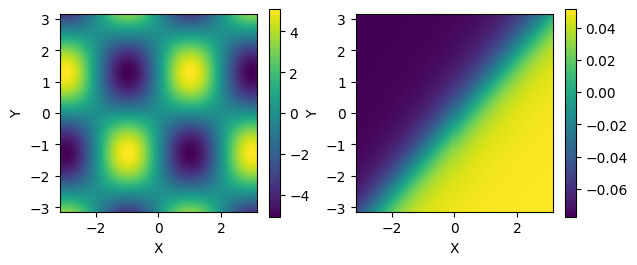

Epoch 10/2000
Data Loss: 1.5237118601799011, PDE Loss: 0.009101170115172863, Total Loss: 1.532813012599945, LR: 0.019998522186878982
Epoch 20/2000
Data Loss: 1.5057912468910217, PDE Loss: 0.011004182044416666, Total Loss: 1.5167954564094543, LR: 0.01999461427515605
Epoch 30/2000
Data Loss: 1.5153717994689941, PDE Loss: 0.019704929552972317, Total Loss: 1.5350767374038696, LR: 0.01998826501541702
Epoch 40/2000
Data Loss: 1.4758923649787903, PDE Loss: 0.018105355091392994, Total Loss: 1.4939977526664734, LR: 0.019979475974246718
Task :: A=5.093690735623753, B=1.2287257784195504, C=1.5810637532866647
Test MSE Loss :  1.950159254787561


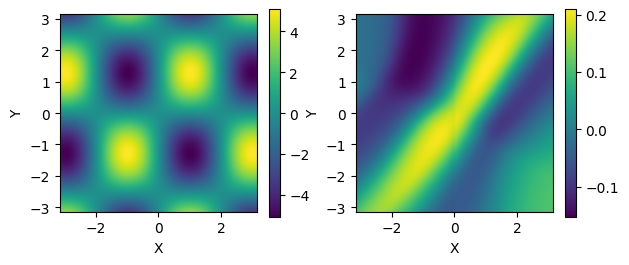

Epoch 50/2000
Data Loss: 1.4833887815475464, PDE Loss: 0.013414876069873571, Total Loss: 1.496803641319275, LR: 0.019968249320209543
Epoch 60/2000
Data Loss: 1.5133565068244934, PDE Loss: 0.01469821808859706, Total Loss: 1.5280547738075256, LR: 0.01995458782331439
Epoch 70/2000
Data Loss: 1.4414277076721191, PDE Loss: 0.04059715196490288, Total Loss: 1.482024908065796, LR: 0.0199384948543312
Epoch 80/2000
Data Loss: 1.4889798164367676, PDE Loss: 0.02417039405554533, Total Loss: 1.5131502151489258, LR: 0.01991997438395926
Epoch 90/2000
Data Loss: 1.3777374029159546, PDE Loss: 0.12222518026828766, Total Loss: 1.499962568283081, LR: 0.019899030981847508
Task :: A=5.093690735623753, B=1.2287257784195504, C=1.5810637532866647
Test MSE Loss :  1.9284231845978785


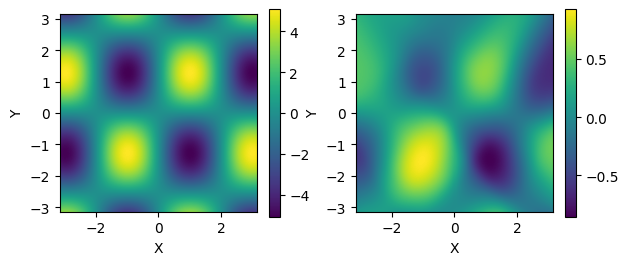

Epoch 100/2000
Data Loss: 1.3088030815124512, PDE Loss: 0.12143431603908539, Total Loss: 1.4302374124526978, LR: 0.019875669815467036
Epoch 110/2000
Data Loss: 1.2224735617637634, PDE Loss: 0.12822524458169937, Total Loss: 1.3506988286972046, LR: 0.019849896648836084
Epoch 120/2000
Data Loss: 1.1673261523246765, PDE Loss: 0.21339403837919235, Total Loss: 1.3807201981544495, LR: 0.019821717841097868
Epoch 130/2000
Data Loss: 1.0455976724624634, PDE Loss: 0.2953498885035515, Total Loss: 1.3409475684165955, LR: 0.019791140344951545
Epoch 140/2000
Data Loss: 0.9633660316467285, PDE Loss: 0.24517476558685303, Total Loss: 1.2085407972335815, LR: 0.01975817170493675
Epoch 150/2000
Data Loss: 0.91690993309021, PDE Loss: 0.31558454036712646, Total Loss: 1.2324944734573364, LR: 0.01972282005557209
Epoch 160/2000
Data Loss: 1.032196581363678, PDE Loss: 0.2242351621389389, Total Loss: 1.256431758403778, LR: 0.019685094119348066
Epoch 170/2000
Data Loss: 0.7999015152454376, PDE Loss: 0.565883591771

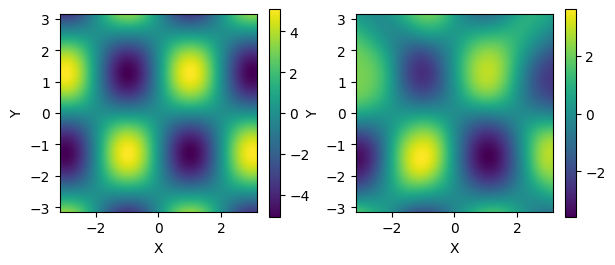

Epoch 200/2000
Data Loss: 0.5480517446994781, PDE Loss: 0.5896932184696198, Total Loss: 1.137744963169098, LR: 0.019510642410122164
Epoch 210/2000
Data Loss: 0.521909773349762, PDE Loss: 0.500001534819603, Total Loss: 1.0219113230705261, LR: 0.01946119629724703
Epoch 220/2000
Data Loss: 0.8335216641426086, PDE Loss: 0.4341081827878952, Total Loss: 1.267629861831665, LR: 0.019409440449260143
Epoch 230/2000
Data Loss: 0.49544626474380493, PDE Loss: 1.0367584526538849, Total Loss: 1.5322047472000122, LR: 0.019355387636142543
Epoch 240/2000
Data Loss: 0.29066771268844604, PDE Loss: 0.5102237462997437, Total Loss: 0.8008914589881897, LR: 0.019299051194617067
Epoch 250/2000
Data Loss: 0.301788866519928, PDE Loss: 0.4950113445520401, Total Loss: 0.7968001961708069, LR: 0.019240445024857673
Epoch 260/2000
Data Loss: 0.3154895603656769, PDE Loss: 0.5714534819126129, Total Loss: 0.8869430422782898, LR: 0.019179583587059814
Epoch 270/2000
Data Loss: 0.31038160622119904, PDE Loss: 0.64226683974266

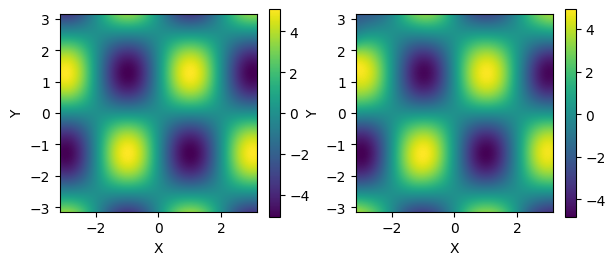

Epoch 500/2000
Data Loss: 0.029760967940092087, PDE Loss: 0.15909669548273087, Total Loss: 0.18885765969753265, LR: 0.017089352366654185
Epoch 510/2000
Data Loss: 0.018727198243141174, PDE Loss: 0.12130360305309296, Total Loss: 0.14003080129623413, LR: 0.016978360692740967
Epoch 520/2000
Data Loss: 0.022633614018559456, PDE Loss: 0.13997961208224297, Total Loss: 0.16261322796344757, LR: 0.016865671886249933
Epoch 530/2000
Data Loss: 0.01597518613561988, PDE Loss: 0.07252169772982597, Total Loss: 0.08849688619375229, LR: 0.01675131375145789
Epoch 540/2000
Data Loss: 0.013118015136569738, PDE Loss: 0.08274053037166595, Total Loss: 0.09585854783654213, LR: 0.016635314504523418
Epoch 550/2000
Data Loss: 0.010926656424999237, PDE Loss: 0.08005892857909203, Total Loss: 0.09098558500409126, LR: 0.016517702766524964
Epoch 560/2000
Data Loss: 0.014383978210389614, PDE Loss: 0.07609622552990913, Total Loss: 0.09048020467162132, LR: 0.01639850755639902
Epoch 570/2000
Data Loss: 0.0194515725597739

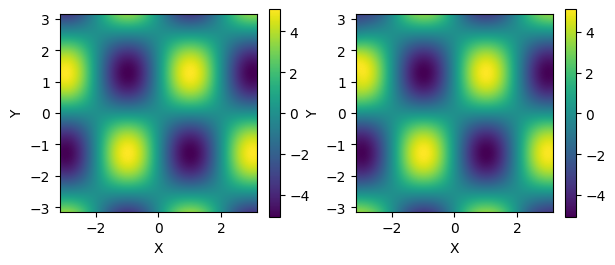

Epoch 1000/2000
Data Loss: 0.0007574173796456307, PDE Loss: 0.0015816939412616193, Total Loss: 0.0023391112918034196, LR: 0.010084449122759775
Epoch 1010/2000
Data Loss: 0.0007612213375978172, PDE Loss: 0.001968002994544804, Total Loss: 0.0027292242739349604, LR: 0.009928948791689294
Epoch 1020/2000
Data Loss: 0.0009277999342884868, PDE Loss: 0.00435077294241637, Total Loss: 0.005278572905808687, LR: 0.009773490664944966
Epoch 1030/2000
Data Loss: 0.001299207389820367, PDE Loss: 0.005694706924259663, Total Loss: 0.0069939144887030125, LR: 0.009618113099493399
Epoch 1040/2000
Data Loss: 0.0007770999218337238, PDE Loss: 0.0020817226613871753, Total Loss: 0.002858822583220899, LR: 0.009462854432423905
Epoch 1050/2000
Data Loss: 0.0006487330538220704, PDE Loss: 0.001157859107479453, Total Loss: 0.0018065921613015234, LR: 0.009307752971489397
Epoch 1060/2000
Data Loss: 0.0006465844926424325, PDE Loss: 0.0011253671254962683, Total Loss: 0.0017719516181387007, LR: 0.009152846985654524
Epoch 1

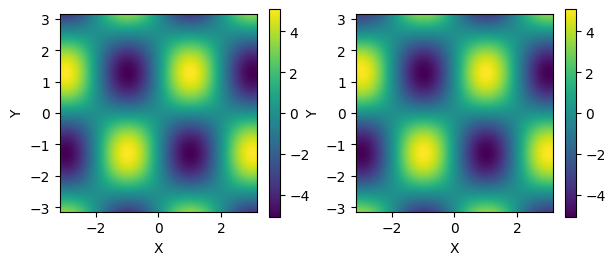

total loss :  0.0005564591847360134
DATA  loss :  0.0003195391327608377
PDE   loss :  0.00023692006652709097


IndexError: list index out of range

In [65]:
for inter_task in inter_tasks:
    print("-"*100)
    print("-"*100)
    model = MultiScaleMLPSequential(
        in_dim=2,
        out_dim=1,
        layers=7,
        neurons=32,
        residual=True,
        subnets=2,
        base_scale=1.1,
        in_scale= [2*np.pi,2*np.pi],
        in_center=[0, 0],
        vec_scen=2,
        vec_size=12,
    )
    model.load_state_dict(torch.load(f"./data/MAD_model.pt"))
    model = model.to(device)
    # loss
    criterion = nn.SmoothL1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
    # scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=20, verbose=False)
    scheduler = CosineAnnealingWarmRestarts(optimizer, 2000, T_mult=1, eta_min=0.0002)

    # init
    loss_history = []
    data_loss_history = []
    pde_loss_history = []
    l1_loss_history = []

    best_loss = float('inf')
    transfer_model(model, inter_task, epochs,save_title="pretrained")

total loss :  0.0005564591847360134
DATA  loss :  0.0003195391327608377
PDE   loss :  0.00023692006652709097


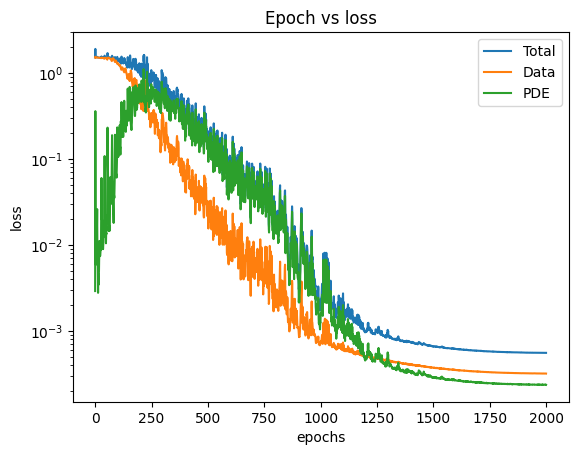

In [67]:
    # 손실값 그래프를 그립니다.
    print("total loss : ",loss_history[-1])
    print("DATA  loss : ",data_loss_history[-1])
    print("PDE   loss : ",pde_loss_history[-1])
    plt.semilogy(loss_history, label="Total")
    plt.semilogy(data_loss_history, label="Data")
    plt.semilogy(pde_loss_history, label="PDE")
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title('Epoch vs loss')
    plt.legend()
    plt.show()

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Epoch 0/2000
Data Loss: 1.318962574005127, PDE Loss: 0.002607042806976878, Total Loss: 1.3215696215629578, LR: 0.019999987786367066
Task :: A=4.487807434590005, B=1.543674181647733, C=1.0813534333913433
Test MSE Loss :  1.7357379569687088


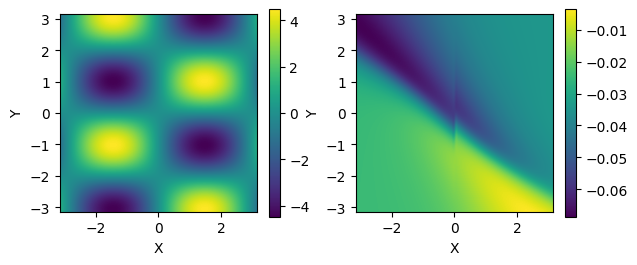

Epoch 10/2000
Data Loss: 1.3161810040473938, PDE Loss: 0.004654180258512497, Total Loss: 1.3208351731300354, LR: 0.019998522186878982
Epoch 20/2000
Data Loss: 1.3059710264205933, PDE Loss: 0.011391526088118553, Total Loss: 1.3173625469207764, LR: 0.01999461427515605
Epoch 30/2000
Data Loss: 1.2694303393363953, PDE Loss: 0.022342153824865818, Total Loss: 1.291772484779358, LR: 0.01998826501541702
Epoch 40/2000
Data Loss: 1.2712966203689575, PDE Loss: 0.028571142349392176, Total Loss: 1.2998678088188171, LR: 0.019979475974246718
Task :: A=4.487807434590005, B=1.543674181647733, C=1.0813534333913433
Test MSE Loss :  1.7252072333957282


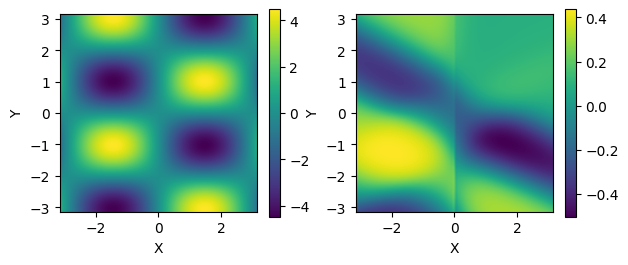

Epoch 50/2000
Data Loss: 1.2035354375839233, PDE Loss: 0.05614900961518288, Total Loss: 1.259684443473816, LR: 0.019968249320209543
Epoch 60/2000
Data Loss: 1.1717388033866882, PDE Loss: 0.05337712913751602, Total Loss: 1.225115954875946, LR: 0.01995458782331439
Epoch 70/2000
Data Loss: 1.1303670406341553, PDE Loss: 0.08578302338719368, Total Loss: 1.2161500453948975, LR: 0.0199384948543312
Epoch 80/2000
Data Loss: 1.0847598314285278, PDE Loss: 0.10091250389814377, Total Loss: 1.1856723427772522, LR: 0.01991997438395926
Epoch 90/2000
Data Loss: 1.170025646686554, PDE Loss: 0.0688798539340496, Total Loss: 1.2389055490493774, LR: 0.019899030981847508
Task :: A=4.487807434590005, B=1.543674181647733, C=1.0813534333913433
Test MSE Loss :  1.697360646773719


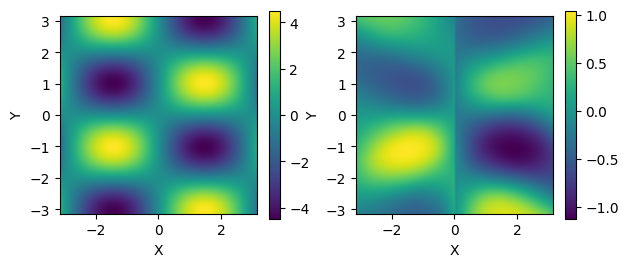

Epoch 100/2000
Data Loss: 1.0171084105968475, PDE Loss: 0.1301780417561531, Total Loss: 1.1472864747047424, LR: 0.019875669815467036
Epoch 110/2000
Data Loss: 0.802695244550705, PDE Loss: 0.24032426625490189, Total Loss: 1.0430194735527039, LR: 0.019849896648836084
Epoch 120/2000
Data Loss: 0.8229460418224335, PDE Loss: 0.2446119636297226, Total Loss: 1.0675579905509949, LR: 0.019821717841097868
Epoch 130/2000
Data Loss: 0.5659202635288239, PDE Loss: 0.32026682794094086, Total Loss: 0.8861870765686035, LR: 0.019791140344951545
Epoch 140/2000
Data Loss: 0.39064401388168335, PDE Loss: 0.4109305143356323, Total Loss: 0.8015745282173157, LR: 0.01975817170493675
Epoch 150/2000
Data Loss: 0.28608348965644836, PDE Loss: 0.4506186544895172, Total Loss: 0.7367021441459656, LR: 0.01972282005557209
Epoch 160/2000
Data Loss: 0.304766520857811, PDE Loss: 0.600587010383606, Total Loss: 0.9053535163402557, LR: 0.019685094119348066
Epoch 170/2000
Data Loss: 0.40376628935337067, PDE Loss: 0.37494526803

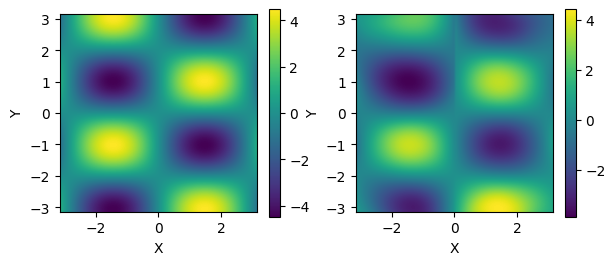

Epoch 200/2000
Data Loss: 0.16365931183099747, PDE Loss: 0.343082994222641, Total Loss: 0.5067422986030579, LR: 0.019510642410122164
Epoch 210/2000
Data Loss: 0.15095464885234833, PDE Loss: 0.4110586494207382, Total Loss: 0.5620133131742477, LR: 0.01946119629724703
Epoch 220/2000
Data Loss: 0.12528705969452858, PDE Loss: 0.4234132468700409, Total Loss: 0.548700287938118, LR: 0.019409440449260143
Epoch 230/2000
Data Loss: 0.09853332117199898, PDE Loss: 0.2887929379940033, Total Loss: 0.38732627034187317, LR: 0.019355387636142543
Epoch 240/2000
Data Loss: 0.09952222928404808, PDE Loss: 0.27637651562690735, Total Loss: 0.3758987486362457, LR: 0.019299051194617067
Epoch 250/2000
Data Loss: 0.11865926161408424, PDE Loss: 0.42911654710769653, Total Loss: 0.5477758198976517, LR: 0.019240445024857673
Epoch 260/2000
Data Loss: 0.02813615184277296, PDE Loss: 0.12898436933755875, Total Loss: 0.15712051838636398, LR: 0.019179583587059814
Epoch 270/2000
Data Loss: 0.025561437010765076, PDE Loss: 0.

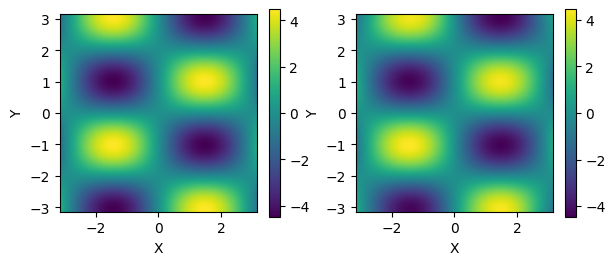

Epoch 500/2000
Data Loss: 0.003917441586963832, PDE Loss: 0.030754948034882545, Total Loss: 0.0346723897382617, LR: 0.017089352366654185
Epoch 510/2000
Data Loss: 0.005197175079956651, PDE Loss: 0.036685213446617126, Total Loss: 0.041882388293743134, LR: 0.016978360692740967
Epoch 520/2000
Data Loss: 0.006362262414768338, PDE Loss: 0.030269489623606205, Total Loss: 0.036631752736866474, LR: 0.016865671886249933
Epoch 530/2000
Data Loss: 0.007260513724759221, PDE Loss: 0.043419770896434784, Total Loss: 0.05068028345704079, LR: 0.01675131375145789
Epoch 540/2000
Data Loss: 0.004112360649742186, PDE Loss: 0.021777339279651642, Total Loss: 0.025889700278639793, LR: 0.016635314504523418
Epoch 550/2000
Data Loss: 0.0073170403484255075, PDE Loss: 0.05843219347298145, Total Loss: 0.06574923545122147, LR: 0.016517702766524964
Epoch 560/2000
Data Loss: 0.009589106775820255, PDE Loss: 0.06940587796270847, Total Loss: 0.0789949856698513, LR: 0.01639850755639902
Epoch 570/2000
Data Loss: 0.00350708

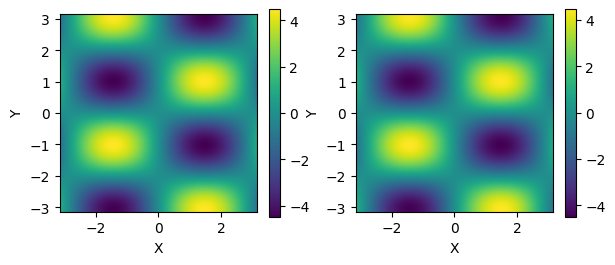

Epoch 1000/2000
Data Loss: 0.00032201399153564125, PDE Loss: 0.00212753564119339, Total Loss: 0.002449549618177116, LR: 0.010084449122759775
Epoch 1010/2000
Data Loss: 0.00018019157141679898, PDE Loss: 0.0010642455308698118, Total Loss: 0.0012444371241144836, LR: 0.009928948791689294
Epoch 1020/2000
Data Loss: 0.0001418118627043441, PDE Loss: 0.0006996260781306773, Total Loss: 0.0008414379553869367, LR: 0.009773490664944966
Epoch 1030/2000
Data Loss: 0.0001450886484235525, PDE Loss: 0.0008121725113596767, Total Loss: 0.0009572611888870597, LR: 0.009618113099493399
Epoch 1040/2000
Data Loss: 0.00012092229735571891, PDE Loss: 0.000586988840950653, Total Loss: 0.0007079111237544566, LR: 0.009462854432423905
Epoch 1050/2000
Data Loss: 0.00013962051161797717, PDE Loss: 0.0007403239142149687, Total Loss: 0.0008799444185569882, LR: 0.009307752971489397
Epoch 1060/2000
Data Loss: 0.00012072881509084255, PDE Loss: 0.0005611014494206756, Total Loss: 0.0006818302790634334, LR: 0.00915284698565452

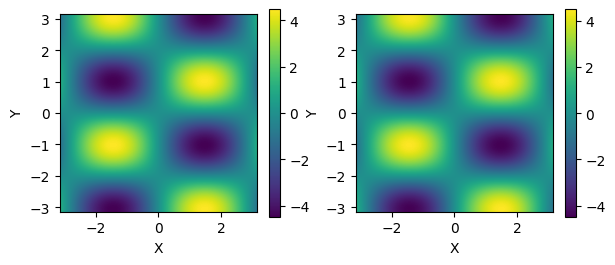

total loss :  0.00022156316845212132
DATA  loss :  5.028722807765007e-05
PDE   loss :  0.00017127594037447125


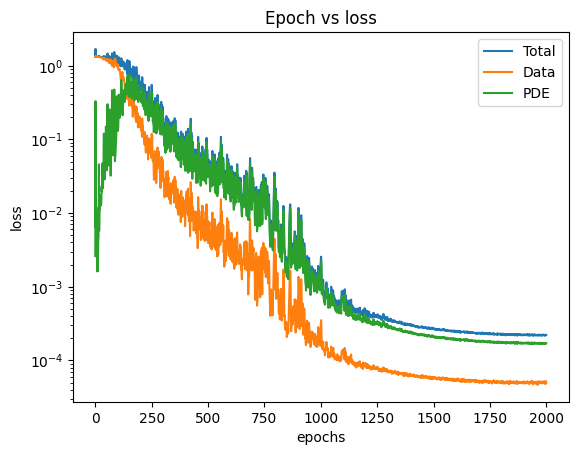

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Epoch 0/2000
Data Loss: 0.6978228986263275, PDE Loss: 0.003981311165173196, Total Loss: 0.7018041908740997, LR: 0.019999987786367066
Task :: A=2.777942819756045, B=1.7213625675027244, C=1.216882697534249
Test MSE Loss :  1.0857483070546512


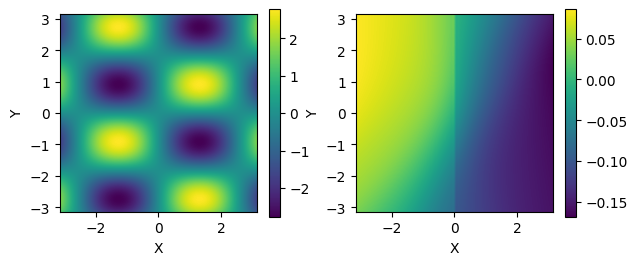

Epoch 10/2000
Data Loss: 0.7058388292789459, PDE Loss: 0.1386576108634472, Total Loss: 0.8444964289665222, LR: 0.019998522186878982
Epoch 20/2000
Data Loss: 0.693909227848053, PDE Loss: 0.001009046216495335, Total Loss: 0.6949182748794556, LR: 0.01999461427515605
Epoch 30/2000
Data Loss: 0.6810015141963959, PDE Loss: 0.0034571026917546988, Total Loss: 0.6844586133956909, LR: 0.01998826501541702
Epoch 40/2000
Data Loss: 0.6397367715835571, PDE Loss: 0.017661137506365776, Total Loss: 0.6573978960514069, LR: 0.019979475974246718
Task :: A=2.777942819756045, B=1.7213625675027244, C=1.216882697534249
Test MSE Loss :  1.0870842306858939


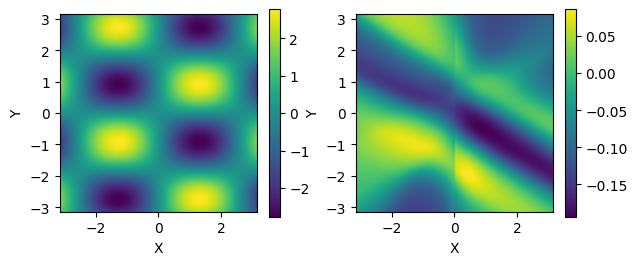

Epoch 50/2000
Data Loss: 0.6642318069934845, PDE Loss: 0.023653223179280758, Total Loss: 0.6878850162029266, LR: 0.019968249320209543
Epoch 60/2000
Data Loss: 0.617937296628952, PDE Loss: 0.020249703899025917, Total Loss: 0.6381869912147522, LR: 0.01995458782331439
Epoch 70/2000
Data Loss: 0.6052049100399017, PDE Loss: 0.034862322732806206, Total Loss: 0.6400672495365143, LR: 0.0199384948543312
Epoch 80/2000
Data Loss: 0.6096465885639191, PDE Loss: 0.07400784268975258, Total Loss: 0.6836544275283813, LR: 0.01991997438395926
Epoch 90/2000
Data Loss: 0.5721515715122223, PDE Loss: 0.04179210215806961, Total Loss: 0.6139436662197113, LR: 0.019899030981847508
Task :: A=2.777942819756045, B=1.7213625675027244, C=1.216882697534249
Test MSE Loss :  1.0726479944227656


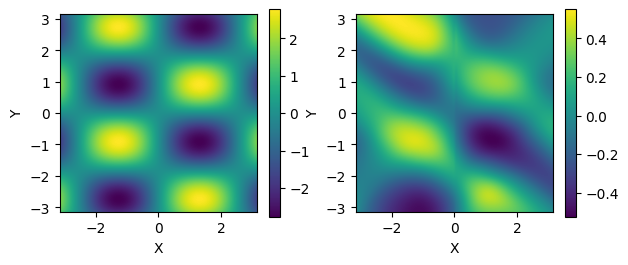

Epoch 100/2000
Data Loss: 0.554580420255661, PDE Loss: 0.05801442265510559, Total Loss: 0.6125948429107666, LR: 0.019875669815467036
Epoch 110/2000
Data Loss: 0.5094258785247803, PDE Loss: 0.11806618049740791, Total Loss: 0.6274920701980591, LR: 0.019849896648836084
Epoch 120/2000
Data Loss: 0.47293803095817566, PDE Loss: 0.14460861310362816, Total Loss: 0.6175466477870941, LR: 0.019821717841097868
Epoch 130/2000
Data Loss: 0.42608742415905, PDE Loss: 0.14014628902077675, Total Loss: 0.5662337243556976, LR: 0.019791140344951545
Epoch 140/2000
Data Loss: 0.37438803911209106, PDE Loss: 0.17004278302192688, Total Loss: 0.5444307923316956, LR: 0.01975817170493675
Epoch 150/2000
Data Loss: 0.3476790487766266, PDE Loss: 0.24031544476747513, Total Loss: 0.5879944860935211, LR: 0.01972282005557209
Epoch 160/2000
Data Loss: 0.309103399515152, PDE Loss: 0.29924042522907257, Total Loss: 0.6083438396453857, LR: 0.019685094119348066
Epoch 170/2000
Data Loss: 0.2604210674762726, PDE Loss: 0.21744991

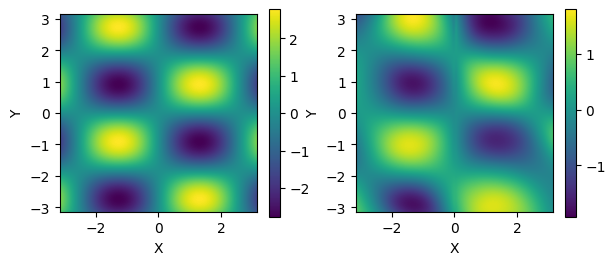

Epoch 200/2000
Data Loss: 0.18232756853103638, PDE Loss: 0.17921078205108643, Total Loss: 0.3615383505821228, LR: 0.019510642410122164
Epoch 210/2000
Data Loss: 0.1357896812260151, PDE Loss: 0.29609064012765884, Total Loss: 0.43188032507896423, LR: 0.01946119629724703
Epoch 220/2000
Data Loss: 0.11039547994732857, PDE Loss: 0.14336729794740677, Total Loss: 0.25376277416944504, LR: 0.019409440449260143
Epoch 230/2000
Data Loss: 0.18475493043661118, PDE Loss: 0.24598459154367447, Total Loss: 0.43073952198028564, LR: 0.019355387636142543
Epoch 240/2000
Data Loss: 0.10483086481690407, PDE Loss: 0.22513045370578766, Total Loss: 0.32996131479740143, LR: 0.019299051194617067
Epoch 250/2000
Data Loss: 0.07133151218295097, PDE Loss: 0.14446395263075829, Total Loss: 0.21579547226428986, LR: 0.019240445024857673
Epoch 260/2000
Data Loss: 0.06443028897047043, PDE Loss: 0.12271992862224579, Total Loss: 0.18715022504329681, LR: 0.019179583587059814
Epoch 270/2000
Data Loss: 0.05750886723399162, PDE 

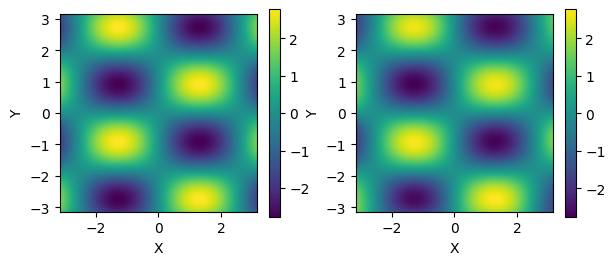

Epoch 500/2000
Data Loss: 0.004173636785708368, PDE Loss: 0.029712380841374397, Total Loss: 0.0338860172778368, LR: 0.017089352366654185
Epoch 510/2000
Data Loss: 0.006645563989877701, PDE Loss: 0.05383419618010521, Total Loss: 0.06047976016998291, LR: 0.016978360692740967
Epoch 520/2000
Data Loss: 0.0027568809455260634, PDE Loss: 0.020678390748798847, Total Loss: 0.023435271345078945, LR: 0.016865671886249933
Epoch 530/2000
Data Loss: 0.0019309388590045273, PDE Loss: 0.010654859244823456, Total Loss: 0.012585797812789679, LR: 0.01675131375145789
Epoch 540/2000
Data Loss: 0.001836887386161834, PDE Loss: 0.008479310665279627, Total Loss: 0.010316197760403156, LR: 0.016635314504523418
Epoch 550/2000
Data Loss: 0.003449120558798313, PDE Loss: 0.02713439241051674, Total Loss: 0.030583513900637627, LR: 0.016517702766524964
Epoch 560/2000
Data Loss: 0.001401257119141519, PDE Loss: 0.009263379033654928, Total Loss: 0.010664636269211769, LR: 0.01639850755639902
Epoch 570/2000
Data Loss: 0.0019

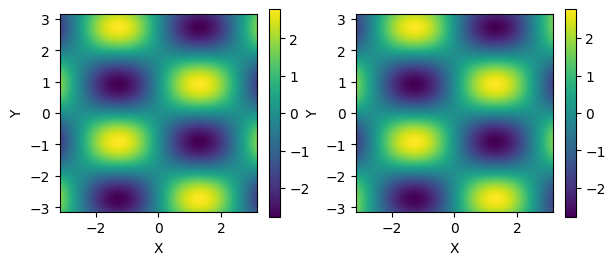

Epoch 1000/2000
Data Loss: 0.00020399236382218078, PDE Loss: 0.0008731599664315581, Total Loss: 0.0010771523229777813, LR: 0.010084449122759775
Epoch 1010/2000
Data Loss: 0.00015965112106641755, PDE Loss: 0.0004891318531008437, Total Loss: 0.0006487829668913037, LR: 0.009928948791689294
Epoch 1020/2000
Data Loss: 0.0001969211662071757, PDE Loss: 0.0008402128878515214, Total Loss: 0.0010371340904384851, LR: 0.009773490664944966
Epoch 1030/2000
Data Loss: 0.00014250817184802145, PDE Loss: 0.0003378817345947027, Total Loss: 0.0004803899209946394, LR: 0.009618113099493399
Epoch 1040/2000
Data Loss: 0.00013253029464976862, PDE Loss: 0.0002939112455351278, Total Loss: 0.00042644154746085405, LR: 0.009462854432423905
Epoch 1050/2000
Data Loss: 0.00013265167217468843, PDE Loss: 0.00030806420545559376, Total Loss: 0.0004407158849062398, LR: 0.009307752971489397
Epoch 1060/2000
Data Loss: 0.00013594174379250035, PDE Loss: 0.0003476605925243348, Total Loss: 0.00048360234359279275, LR: 0.009152846

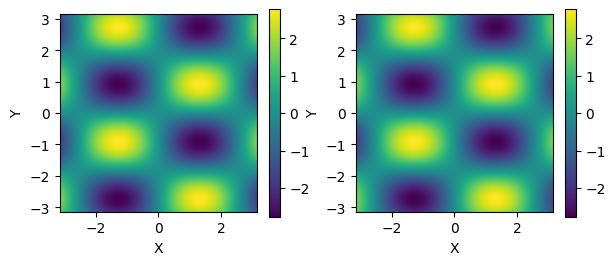

total loss :  0.00015245637769112363
DATA  loss :  5.979240813758224e-05
PDE   loss :  9.266396955354139e-05


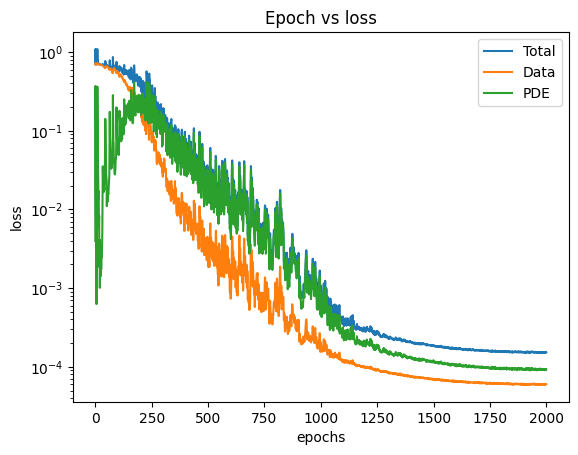

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Epoch 0/2000
Data Loss: 3.8150819540023804, PDE Loss: 0.002696124446995185, Total Loss: 3.817777991294861, LR: 0.019999987786367066
Task :: A=9.374984508659168, B=0.6460623338874734, C=1.9654454951206688
Test MSE Loss :  4.2857337766922114


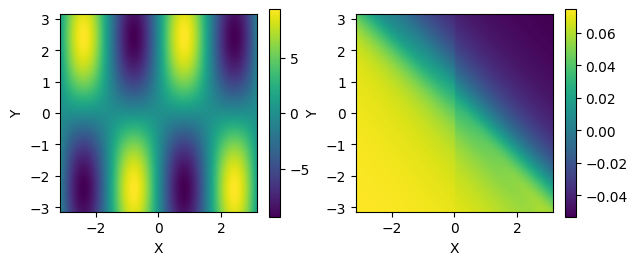

Epoch 10/2000
Data Loss: 3.811745285987854, PDE Loss: 0.01755155110731721, Total Loss: 3.829296827316284, LR: 0.019998522186878982
Epoch 20/2000
Data Loss: 3.809770941734314, PDE Loss: 0.028673234395682812, Total Loss: 3.8384441137313843, LR: 0.01999461427515605
Epoch 30/2000
Data Loss: 3.7415647506713867, PDE Loss: 0.10550858452916145, Total Loss: 3.8470733165740967, LR: 0.01998826501541702
Epoch 40/2000
Data Loss: 3.682518720626831, PDE Loss: 0.10934467241168022, Total Loss: 3.791863441467285, LR: 0.019979475974246718
Task :: A=9.374984508659168, B=0.6460623338874734, C=1.9654454951206688
Test MSE Loss :  4.272442084533047


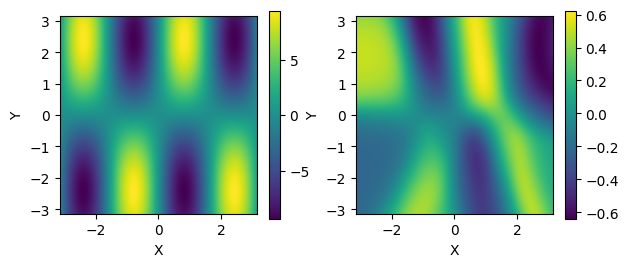

Epoch 50/2000
Data Loss: 3.59036123752594, PDE Loss: 0.21902842819690704, Total Loss: 3.8093897104263306, LR: 0.019968249320209543
Epoch 60/2000
Data Loss: 3.5141758918762207, PDE Loss: 0.15302765369415283, Total Loss: 3.6672035455703735, LR: 0.01995458782331439
Epoch 70/2000
Data Loss: 3.4172838926315308, PDE Loss: 0.2642510458827019, Total Loss: 3.681535005569458, LR: 0.0199384948543312
Epoch 80/2000
Data Loss: 3.3778188228607178, PDE Loss: 0.2681748569011688, Total Loss: 3.6459935903549194, LR: 0.01991997438395926
Epoch 90/2000
Data Loss: 3.217064619064331, PDE Loss: 0.5188994407653809, Total Loss: 3.735964059829712, LR: 0.019899030981847508
Task :: A=9.374984508659168, B=0.6460623338874734, C=1.9654454951206688
Test MSE Loss :  4.219788740391625


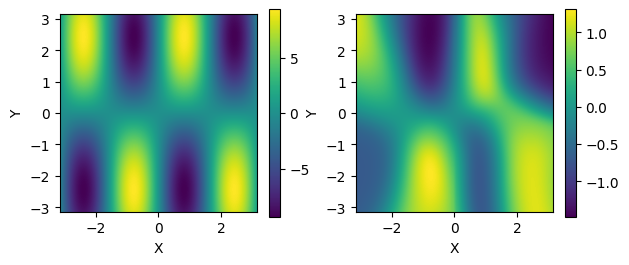

Epoch 100/2000
Data Loss: 3.300172805786133, PDE Loss: 0.4358111023902893, Total Loss: 3.735983967781067, LR: 0.019875669815467036
Epoch 110/2000
Data Loss: 3.3091280460357666, PDE Loss: 0.3462241142988205, Total Loss: 3.6553521156311035, LR: 0.019849896648836084
Epoch 120/2000
Data Loss: 3.172765612602234, PDE Loss: 0.3796623945236206, Total Loss: 3.5524280071258545, LR: 0.019821717841097868
Epoch 130/2000
Data Loss: 3.100329637527466, PDE Loss: 0.32006025314331055, Total Loss: 3.4203898906707764, LR: 0.019791140344951545
Epoch 140/2000
Data Loss: 2.767312169075012, PDE Loss: 0.8945377171039581, Total Loss: 3.661849856376648, LR: 0.01975817170493675
Epoch 150/2000
Data Loss: 2.597953677177429, PDE Loss: 1.125651866197586, Total Loss: 3.723605513572693, LR: 0.01972282005557209
Epoch 160/2000
Data Loss: 2.6853604316711426, PDE Loss: 0.8887580037117004, Total Loss: 3.574118494987488, LR: 0.019685094119348066
Epoch 170/2000
Data Loss: 2.7153321504592896, PDE Loss: 0.8972134590148926, Tota

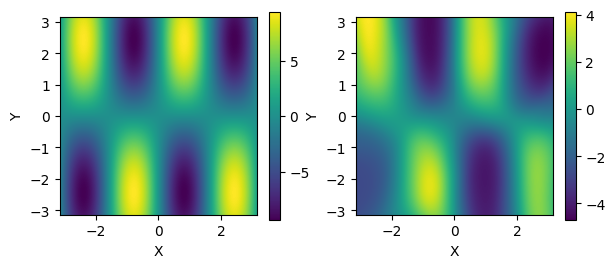

Epoch 200/2000
Data Loss: 2.0660074949264526, PDE Loss: 1.2959789633750916, Total Loss: 3.3619863986968994, LR: 0.019510642410122164
Epoch 210/2000
Data Loss: 1.9821274876594543, PDE Loss: 1.3756821751594543, Total Loss: 3.3578097820281982, LR: 0.01946119629724703
Epoch 220/2000
Data Loss: 1.8431323766708374, PDE Loss: 1.7011571526527405, Total Loss: 3.544289469718933, LR: 0.019409440449260143
Epoch 230/2000
Data Loss: 1.494819164276123, PDE Loss: 1.4677294492721558, Total Loss: 2.962548613548279, LR: 0.019355387636142543
Epoch 240/2000
Data Loss: 1.8404027819633484, PDE Loss: 1.1792290210723877, Total Loss: 3.0196317434310913, LR: 0.019299051194617067
Epoch 250/2000
Data Loss: 1.3567021489143372, PDE Loss: 1.9930453896522522, Total Loss: 3.3497475385665894, LR: 0.019240445024857673
Epoch 260/2000
Data Loss: 1.8779057264328003, PDE Loss: 0.9012278616428375, Total Loss: 2.7791335582733154, LR: 0.019179583587059814
Epoch 270/2000
Data Loss: 1.331943154335022, PDE Loss: 1.714100420475006,

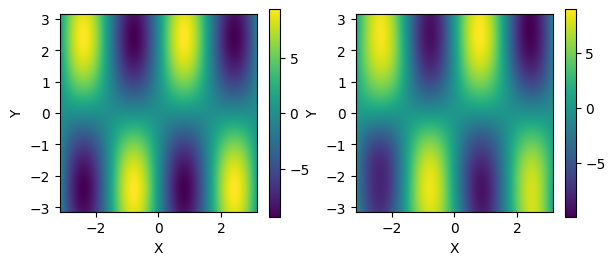

Epoch 500/2000
Data Loss: 0.11435403302311897, PDE Loss: 0.8157343864440918, Total Loss: 0.9300884008407593, LR: 0.017089352366654185
Epoch 510/2000
Data Loss: 0.1733660027384758, PDE Loss: 0.8491135537624359, Total Loss: 1.02247953414917, LR: 0.016978360692740967
Epoch 520/2000
Data Loss: 0.3071551024913788, PDE Loss: 1.2685208916664124, Total Loss: 1.5756760239601135, LR: 0.016865671886249933
Epoch 530/2000
Data Loss: 0.14850743860006332, PDE Loss: 0.747568815946579, Total Loss: 0.8960762619972229, LR: 0.01675131375145789
Epoch 540/2000
Data Loss: 0.13424262031912804, PDE Loss: 0.6804218292236328, Total Loss: 0.8146644532680511, LR: 0.016635314504523418
Epoch 550/2000
Data Loss: 0.2427254319190979, PDE Loss: 0.9912499189376831, Total Loss: 1.233975350856781, LR: 0.016517702766524964
Epoch 560/2000
Data Loss: 0.12493368983268738, PDE Loss: 0.7063865959644318, Total Loss: 0.8313202857971191, LR: 0.01639850755639902
Epoch 570/2000
Data Loss: 0.16211695224046707, PDE Loss: 0.649819403886

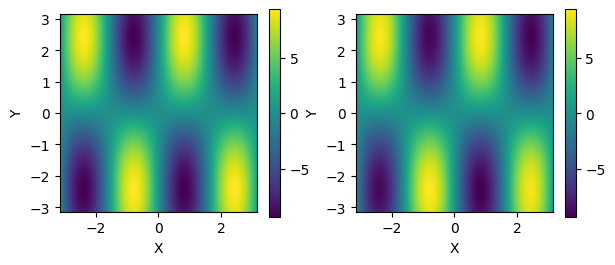

Epoch 1000/2000
Data Loss: 0.01899705734103918, PDE Loss: 0.16674689948558807, Total Loss: 0.18574395775794983, LR: 0.010084449122759775
Epoch 1010/2000
Data Loss: 0.015364828053861856, PDE Loss: 0.16151276230812073, Total Loss: 0.17687759548425674, LR: 0.009928948791689294
Epoch 1020/2000
Data Loss: 0.027411265298724174, PDE Loss: 0.21515116840600967, Total Loss: 0.2425624281167984, LR: 0.009773490664944966
Epoch 1030/2000
Data Loss: 0.004764568759128451, PDE Loss: 0.05446252599358559, Total Loss: 0.05922709405422211, LR: 0.009618113099493399
Epoch 1040/2000
Data Loss: 0.02720397710800171, PDE Loss: 0.23555505275726318, Total Loss: 0.2627590298652649, LR: 0.009462854432423905
Epoch 1050/2000
Data Loss: 0.006500062998384237, PDE Loss: 0.05873658508062363, Total Loss: 0.06523664854466915, LR: 0.009307752971489397
Epoch 1060/2000
Data Loss: 0.001967786345630884, PDE Loss: 0.053517403081059456, Total Loss: 0.05548518896102905, LR: 0.009152846985654524
Epoch 1070/2000
Data Loss: 0.00599527

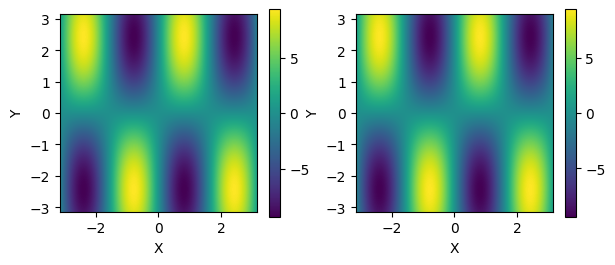

total loss :  0.0013872446143068373
DATA  loss :  0.0001772351679392159
PDE   loss :  0.0012100094463676214


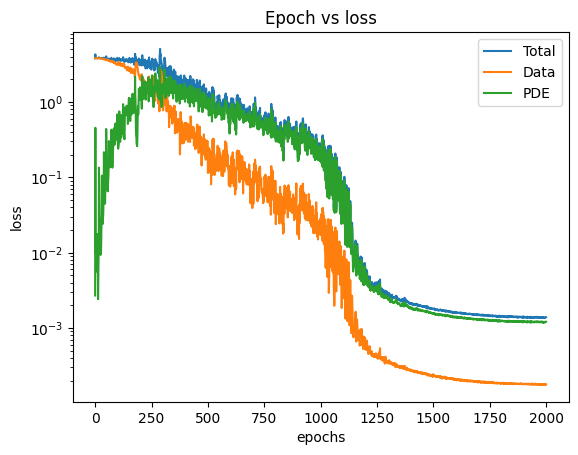

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Epoch 0/2000
Data Loss: 2.7128907442092896, PDE Loss: 0.0009758428179440504, Total Loss: 2.7138665914535522, LR: 0.019999987786367066


Task :: A=7.688984649286316, B=1.0310431618538227, C=0.5454349450272911
Test MSE Loss :  3.0487498353438927


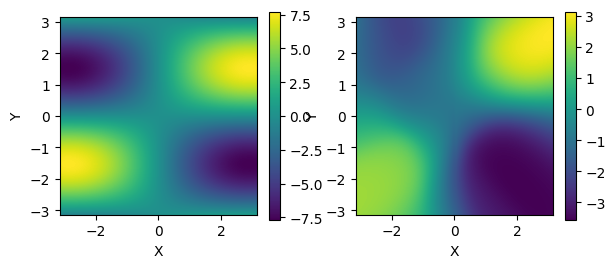

Epoch 10/2000
Data Loss: 1.6172955632209778, PDE Loss: 0.5308941304683685, Total Loss: 2.148189663887024, LR: 0.019998522186878982
Epoch 20/2000
Data Loss: 0.8284679353237152, PDE Loss: 0.6504166722297668, Total Loss: 1.4788845777511597, LR: 0.01999461427515605
Epoch 30/2000
Data Loss: 0.45671533048152924, PDE Loss: 0.6546622812747955, Total Loss: 1.1113775968551636, LR: 0.01998826501541702
Epoch 40/2000
Data Loss: 0.3477553129196167, PDE Loss: 0.6384271383285522, Total Loss: 0.986182451248169, LR: 0.019979475974246718
Task :: A=7.688984649286316, B=1.0310431618538227, C=0.5454349450272911
Test MSE Loss :  1.4550189384034233


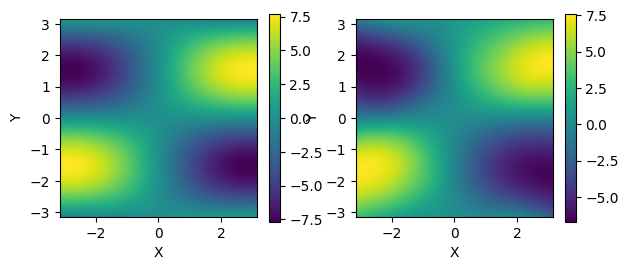

Epoch 50/2000
Data Loss: 0.27762800455093384, PDE Loss: 0.5586460828781128, Total Loss: 0.8362740874290466, LR: 0.019968249320209543
Epoch 60/2000
Data Loss: 0.21049802005290985, PDE Loss: 0.32453276216983795, Total Loss: 0.5350307822227478, LR: 0.01995458782331439
Epoch 70/2000
Data Loss: 0.15874089300632477, PDE Loss: 0.3762413263320923, Total Loss: 0.5349822044372559, LR: 0.0199384948543312
Epoch 80/2000
Data Loss: 0.37604284286499023, PDE Loss: 0.4906615763902664, Total Loss: 0.8667044341564178, LR: 0.01991997438395926
Epoch 90/2000
Data Loss: 0.30046509206295013, PDE Loss: 0.2426944598555565, Total Loss: 0.5431595742702484, LR: 0.019899030981847508
Task :: A=7.688984649286316, B=1.0310431618538227, C=0.5454349450272911
Test MSE Loss :  1.3912830378317127


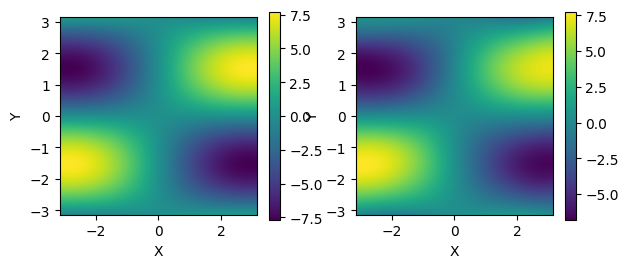

Epoch 100/2000
Data Loss: 0.1572635918855667, PDE Loss: 0.3041997402906418, Total Loss: 0.4614633172750473, LR: 0.019875669815467036
Epoch 110/2000
Data Loss: 0.1246068887412548, PDE Loss: 0.17670875042676926, Total Loss: 0.30131563544273376, LR: 0.019849896648836084
Epoch 120/2000
Data Loss: 0.09154006466269493, PDE Loss: 0.13617562130093575, Total Loss: 0.22771568596363068, LR: 0.019821717841097868
Epoch 130/2000
Data Loss: 0.01819257205352187, PDE Loss: 0.028654033318161964, Total Loss: 0.04684660583734512, LR: 0.019791140344951545
Epoch 140/2000
Data Loss: 0.031423713895492256, PDE Loss: 0.04126118868589401, Total Loss: 0.07268490269780159, LR: 0.01975817170493675
Epoch 150/2000
Data Loss: 0.010795917827636003, PDE Loss: 0.017337819561362267, Total Loss: 0.028133736923336983, LR: 0.01972282005557209
Epoch 160/2000
Data Loss: 0.0014590914361178875, PDE Loss: 0.00414898875169456, Total Loss: 0.0056080801878124475, LR: 0.019685094119348066
Epoch 170/2000
Data Loss: 0.00056875898735597

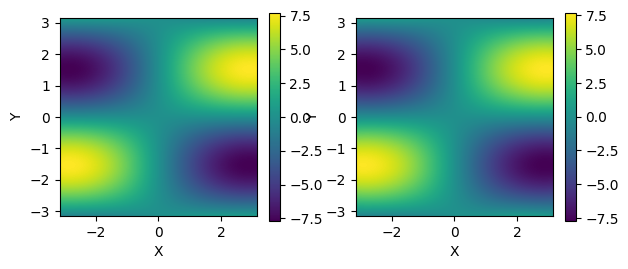

Epoch 200/2000
Data Loss: 0.001132625446189195, PDE Loss: 0.0030993730761110783, Total Loss: 0.004231998580507934, LR: 0.019510642410122164
Epoch 210/2000
Data Loss: 0.0007772008539177477, PDE Loss: 0.002008768846280873, Total Loss: 0.0027859697584062815, LR: 0.01946119629724703
Epoch 220/2000
Data Loss: 0.0005852492467965931, PDE Loss: 0.0015039461432024837, Total Loss: 0.002089195419102907, LR: 0.019409440449260143
Epoch 230/2000
Data Loss: 0.04890758544206619, PDE Loss: 0.04864000342786312, Total Loss: 0.09754759073257446, LR: 0.019355387636142543
Epoch 240/2000
Data Loss: 0.012023857329040766, PDE Loss: 0.01913539320230484, Total Loss: 0.03115925006568432, LR: 0.019299051194617067
Epoch 250/2000
Data Loss: 0.0011932992201764137, PDE Loss: 0.0033167264191433787, Total Loss: 0.004510025610215962, LR: 0.019240445024857673
Epoch 260/2000
Data Loss: 0.0011134688975289464, PDE Loss: 0.002129610860720277, Total Loss: 0.0032430796418339014, LR: 0.019179583587059814
Epoch 270/2000
Data Loss

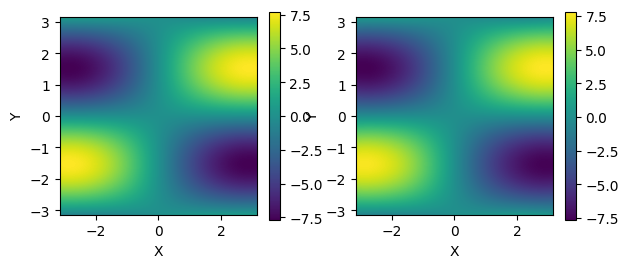

Epoch 500/2000
Data Loss: 0.003510941518470645, PDE Loss: 0.008472975343465805, Total Loss: 0.011983916629105806, LR: 0.017089352366654185
Epoch 510/2000
Data Loss: 0.0015853014774620533, PDE Loss: 0.005833992501720786, Total Loss: 0.007419294212013483, LR: 0.016978360692740967
Epoch 520/2000
Data Loss: 0.00046487040526699275, PDE Loss: 0.001536842668429017, Total Loss: 0.002001713030040264, LR: 0.016865671886249933
Epoch 530/2000
Data Loss: 0.0001295988477068022, PDE Loss: 0.000536903680767864, Total Loss: 0.0006665025430265814, LR: 0.01675131375145789
Epoch 540/2000
Data Loss: 8.105462620733306e-05, PDE Loss: 0.000423466888605617, Total Loss: 0.0005045215220889077, LR: 0.016635314504523418
Epoch 550/2000
Data Loss: 0.00011199104119441472, PDE Loss: 0.0004636461235349998, Total Loss: 0.0005756371538154781, LR: 0.016517702766524964
Epoch 560/2000
Data Loss: 0.00038796769513282925, PDE Loss: 0.000714391382643953, Total Loss: 0.0011023590341210365, LR: 0.01639850755639902
Epoch 570/2000


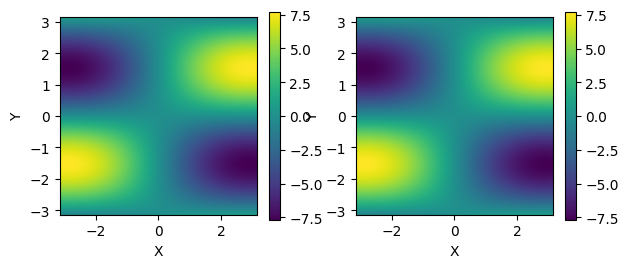

Epoch 1000/2000
Data Loss: 6.401653445209377e-05, PDE Loss: 0.00016846497601363808, Total Loss: 0.00023248150682775304, LR: 0.010084449122759775
Epoch 1010/2000
Data Loss: 2.8670812753261998e-05, PDE Loss: 0.00013891169510316104, Total Loss: 0.00016758251149440184, LR: 0.009928948791689294
Epoch 1020/2000
Data Loss: 8.756651368457824e-05, PDE Loss: 0.00018571958935353905, Total Loss: 0.0002732861030381173, LR: 0.009773490664944966
Epoch 1030/2000
Data Loss: 2.8796087462978903e-05, PDE Loss: 0.00014949061733204871, Total Loss: 0.00017828670388553292, LR: 0.009618113099493399
Epoch 1040/2000
Data Loss: 3.551008467184147e-05, PDE Loss: 0.00012121731924708001, Total Loss: 0.00015672740119043738, LR: 0.009462854432423905
Epoch 1050/2000
Data Loss: 5.5070673624868505e-05, PDE Loss: 0.00014122160791885108, Total Loss: 0.00019629228336270899, LR: 0.009307752971489397
Epoch 1060/2000
Data Loss: 2.5742390789673664e-05, PDE Loss: 0.0001248022381332703, Total Loss: 0.00015054462710395455, LR: 0.00

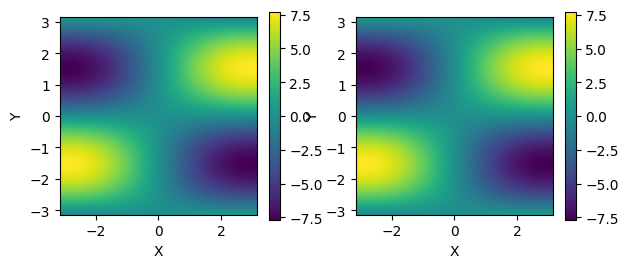

total loss :  4.939968493999913e-05
DATA  loss :  5.931488658461603e-06
PDE   loss :  4.3468196963658556e-05


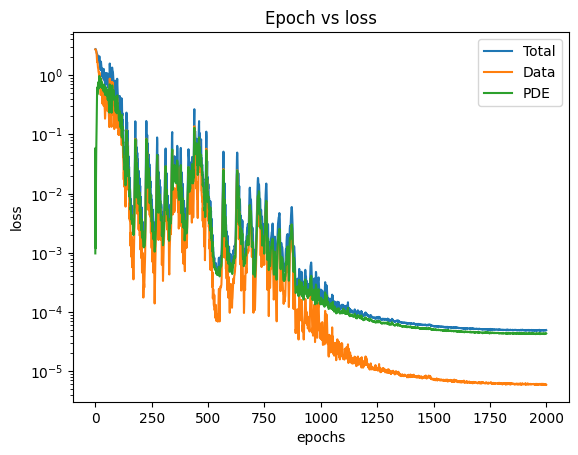

In [71]:
for inter_task in inter_tasks[1:]:
    print("-"*100)
    print("-"*100)
    model = MultiScaleMLPSequential(
        in_dim=2,
        out_dim=1,
        layers=7,
        neurons=32,
        residual=True,
        subnets=2,
        base_scale=1.1,
        in_scale= [2*np.pi,2*np.pi],
        in_center=[0, 0],
        vec_scen=2,
        vec_size=12,
    )
    model.load_state_dict(torch.load(f"./data/MAD_model.pt"))
    model = model.to(device)
    # loss
    criterion = nn.SmoothL1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
    # scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=20, verbose=False)
    scheduler = CosineAnnealingWarmRestarts(optimizer, 2000, T_mult=1, eta_min=0.0002)

    # init
    loss_history = []
    data_loss_history = []
    pde_loss_history = []
    l1_loss_history = []

    best_loss = float('inf')
    transfer_model(model, inter_task, epochs,save_title="pretrained")

## Scatch Learning

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Epoch 0/2000
Data Loss: 1.7641400694847107, PDE Loss: 1.706224113702774, Total Loss: 3.4703640937805176, LR: 0.019999987786367066
Task :: A=5.093690735623753, B=1.2287257784195504, C=1.5810637532866647
Test MSE Loss :  1.952118024796908


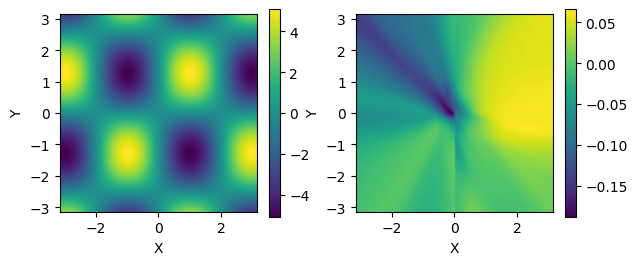

Epoch 10/2000
Data Loss: 1.5178284049034119, PDE Loss: 0.03937317989766598, Total Loss: 1.557201623916626, LR: 0.019998522186878982
Epoch 20/2000
Data Loss: 1.5050949454307556, PDE Loss: 0.007150478661060333, Total Loss: 1.5122454166412354, LR: 0.01999461427515605
Epoch 30/2000
Data Loss: 1.4744551181793213, PDE Loss: 0.013523898087441921, Total Loss: 1.487978994846344, LR: 0.01998826501541702
Epoch 40/2000
Data Loss: 1.4039022326469421, PDE Loss: 0.048445772379636765, Total Loss: 1.452347993850708, LR: 0.019979475974246718
Task :: A=5.093690735623753, B=1.2287257784195504, C=1.5810637532866647
Test MSE Loss :  1.9355307432177582


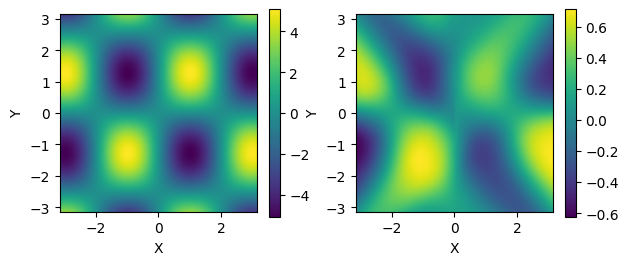

Epoch 50/2000
Data Loss: 1.333375334739685, PDE Loss: 0.09440632537007332, Total Loss: 1.4277816414833069, LR: 0.019968249320209543
Epoch 60/2000
Data Loss: 1.2292584776878357, PDE Loss: 0.10726169124245644, Total Loss: 1.3365201950073242, LR: 0.01995458782331439
Epoch 70/2000
Data Loss: 1.2036967873573303, PDE Loss: 0.13185431063175201, Total Loss: 1.3355510830879211, LR: 0.0199384948543312
Epoch 80/2000
Data Loss: 1.0492796897888184, PDE Loss: 0.3093283772468567, Total Loss: 1.358608067035675, LR: 0.01991997438395926
Epoch 90/2000
Data Loss: 0.9571105241775513, PDE Loss: 0.30507420748472214, Total Loss: 1.262184739112854, LR: 0.019899030981847508
Task :: A=5.093690735623753, B=1.2287257784195504, C=1.5810637532866647
Test MSE Loss :  1.7948180474471027


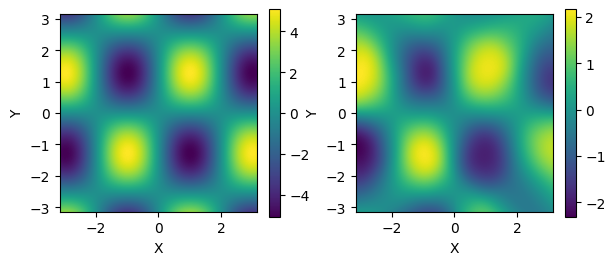

Epoch 100/2000
Data Loss: 0.8655024468898773, PDE Loss: 0.392323836684227, Total Loss: 1.2578262686729431, LR: 0.019875669815467036
Epoch 110/2000
Data Loss: 0.6854490637779236, PDE Loss: 0.4521474391222, Total Loss: 1.1375964879989624, LR: 0.019849896648836084
Epoch 120/2000
Data Loss: 0.6837382316589355, PDE Loss: 0.4769747257232666, Total Loss: 1.1607129573822021, LR: 0.019821717841097868
Epoch 130/2000
Data Loss: 0.4988698363304138, PDE Loss: 0.44960401952266693, Total Loss: 0.9484738707542419, LR: 0.019791140344951545
Epoch 140/2000
Data Loss: 0.45664675533771515, PDE Loss: 0.5168876051902771, Total Loss: 0.9735343754291534, LR: 0.01975817170493675
Epoch 150/2000
Data Loss: 0.3941400647163391, PDE Loss: 0.5884864032268524, Total Loss: 0.9826264381408691, LR: 0.01972282005557209
Epoch 160/2000
Data Loss: 0.24526405334472656, PDE Loss: 0.5575117915868759, Total Loss: 0.8027758598327637, LR: 0.019685094119348066
Epoch 170/2000
Data Loss: 0.3504856377840042, PDE Loss: 0.57084691524505

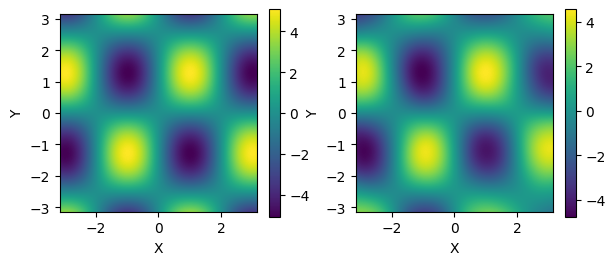

Epoch 200/2000
Data Loss: 0.14336249604821205, PDE Loss: 0.4058490991592407, Total Loss: 0.5492116063833237, LR: 0.019510642410122164
Epoch 210/2000
Data Loss: 0.1265152134001255, PDE Loss: 0.4151473343372345, Total Loss: 0.5416625589132309, LR: 0.01946119629724703
Epoch 220/2000
Data Loss: 0.1278390772640705, PDE Loss: 0.389321967959404, Total Loss: 0.5171610414981842, LR: 0.019409440449260143
Epoch 230/2000
Data Loss: 0.12686241418123245, PDE Loss: 0.4299520403146744, Total Loss: 0.5568144619464874, LR: 0.019355387636142543
Epoch 240/2000
Data Loss: 0.11634286120533943, PDE Loss: 0.3454926013946533, Total Loss: 0.46183545887470245, LR: 0.019299051194617067
Epoch 250/2000
Data Loss: 0.12814242020249367, PDE Loss: 0.37754493951797485, Total Loss: 0.5056873559951782, LR: 0.019240445024857673
Epoch 260/2000
Data Loss: 0.06375718675553799, PDE Loss: 0.25496435910463333, Total Loss: 0.31872154772281647, LR: 0.019179583587059814
Epoch 270/2000
Data Loss: 0.062475359067320824, PDE Loss: 0.23

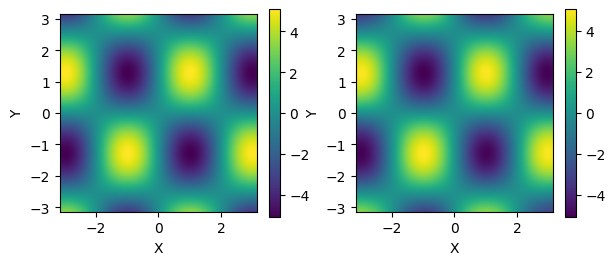

Epoch 500/2000
Data Loss: 0.005408823722973466, PDE Loss: 0.04246828146278858, Total Loss: 0.047877104952931404, LR: 0.017089352366654185
Epoch 510/2000
Data Loss: 0.010796488262712955, PDE Loss: 0.07761803269386292, Total Loss: 0.0884145200252533, LR: 0.016978360692740967
Epoch 520/2000
Data Loss: 0.011458911001682281, PDE Loss: 0.08977032080292702, Total Loss: 0.101229228079319, LR: 0.016865671886249933
Epoch 530/2000
Data Loss: 0.013549636583775282, PDE Loss: 0.0869232527911663, Total Loss: 0.10047288984060287, LR: 0.01675131375145789
Epoch 540/2000
Data Loss: 0.007441940950229764, PDE Loss: 0.05211207643151283, Total Loss: 0.05955401808023453, LR: 0.016635314504523418
Epoch 550/2000
Data Loss: 0.004718914860859513, PDE Loss: 0.036414927802979946, Total Loss: 0.04113384336233139, LR: 0.016517702766524964
Epoch 560/2000
Data Loss: 0.009872590657323599, PDE Loss: 0.07487285509705544, Total Loss: 0.08474544808268547, LR: 0.01639850755639902
Epoch 570/2000
Data Loss: 0.00599192141089588

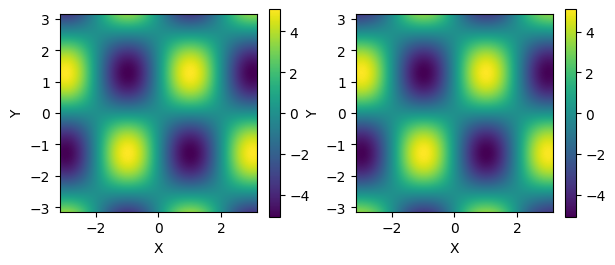

Epoch 1000/2000
Data Loss: 0.0002371507289353758, PDE Loss: 0.0007877245079725981, Total Loss: 0.0010248752078041434, LR: 0.010084449122759775
Epoch 1010/2000
Data Loss: 0.00021224062220426276, PDE Loss: 0.0006283695111051202, Total Loss: 0.0008406101260334253, LR: 0.009928948791689294
Epoch 1020/2000
Data Loss: 0.00022856671421322972, PDE Loss: 0.0007037727336864918, Total Loss: 0.0009323394624516368, LR: 0.009773490664944966
Epoch 1030/2000
Data Loss: 0.00018916087719844654, PDE Loss: 0.0004665933665819466, Total Loss: 0.0006557542365044355, LR: 0.009618113099493399
Epoch 1040/2000
Data Loss: 0.000194213651411701, PDE Loss: 0.0005676496075466275, Total Loss: 0.0007618632807862014, LR: 0.009462854432423905
Epoch 1050/2000
Data Loss: 0.00020183876040391624, PDE Loss: 0.0006072491523809731, Total Loss: 0.0008090879127848893, LR: 0.009307752971489397
Epoch 1060/2000
Data Loss: 0.00018504690524423495, PDE Loss: 0.00043943518539890647, Total Loss: 0.0006244820833671838, LR: 0.0091528469856

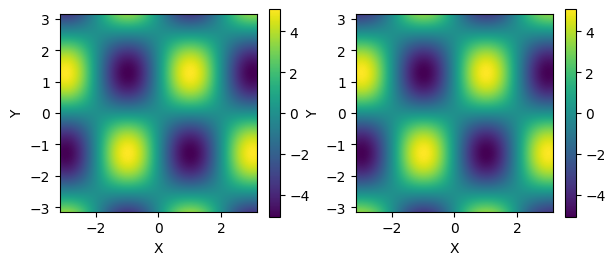

total loss :  0.00022339547285810113
DATA  loss :  9.37698241614271e-05
PDE   loss :  0.00012962565233465284


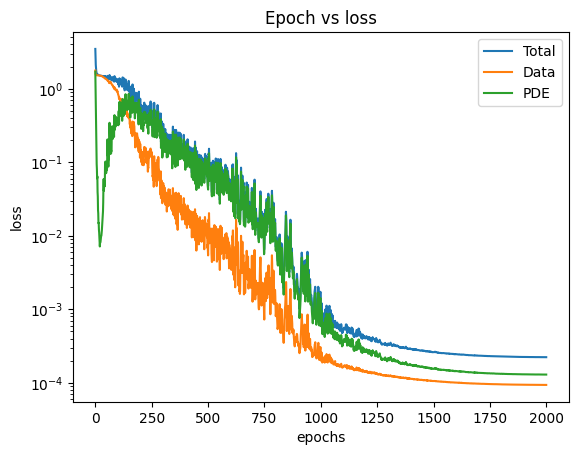

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Epoch 0/2000
Data Loss: 1.7850496768951416, PDE Loss: 2.029303163290024, Total Loss: 3.8143527507781982, LR: 0.019999987786367066
Task :: A=4.487807434590005, B=1.543674181647733, C=1.0813534333913433
Test MSE Loss :  1.7321950302313616


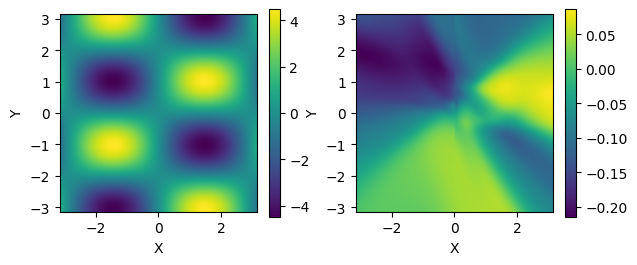

Epoch 10/2000
Data Loss: 1.3015887141227722, PDE Loss: 0.0358028132468462, Total Loss: 1.3373915553092957, LR: 0.019998522186878982
Epoch 20/2000
Data Loss: 1.2434311509132385, PDE Loss: 0.023823494091629982, Total Loss: 1.267254650592804, LR: 0.01999461427515605
Epoch 30/2000
Data Loss: 1.0728402733802795, PDE Loss: 0.10384076088666916, Total Loss: 1.1766809821128845, LR: 0.01998826501541702
Epoch 40/2000
Data Loss: 0.9853511452674866, PDE Loss: 0.12132089585065842, Total Loss: 1.1066719889640808, LR: 0.019979475974246718
Task :: A=4.487807434590005, B=1.543674181647733, C=1.0813534333913433
Test MSE Loss :  1.6462010265875695


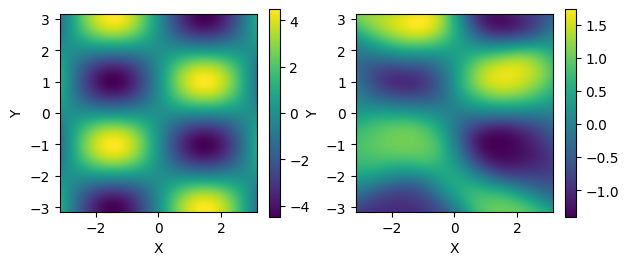

Epoch 50/2000
Data Loss: 0.8429632186889648, PDE Loss: 0.25768861919641495, Total Loss: 1.1006518602371216, LR: 0.019968249320209543
Epoch 60/2000
Data Loss: 0.6894645094871521, PDE Loss: 0.4242590516805649, Total Loss: 1.1137235760688782, LR: 0.01995458782331439
Epoch 70/2000
Data Loss: 0.49017658829689026, PDE Loss: 0.3158169686794281, Total Loss: 0.8059935569763184, LR: 0.0199384948543312
Epoch 80/2000
Data Loss: 0.38609281182289124, PDE Loss: 0.397103488445282, Total Loss: 0.7831963300704956, LR: 0.01991997438395926
Epoch 90/2000
Data Loss: 0.33380964398384094, PDE Loss: 0.32467223703861237, Total Loss: 0.6584818661212921, LR: 0.019899030981847508
Task :: A=4.487807434590005, B=1.543674181647733, C=1.0813534333913433
Test MSE Loss :  1.182306705393895


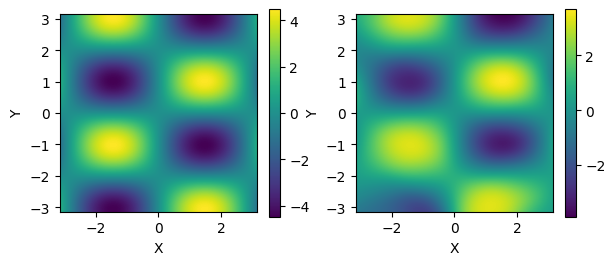

Epoch 100/2000
Data Loss: 0.24542918801307678, PDE Loss: 0.4955844581127167, Total Loss: 0.7410136461257935, LR: 0.019875669815467036
Epoch 110/2000
Data Loss: 0.23508989065885544, PDE Loss: 0.5696058720350266, Total Loss: 0.8046957552433014, LR: 0.019849896648836084
Epoch 120/2000
Data Loss: 0.1286964938044548, PDE Loss: 0.3241041451692581, Total Loss: 0.4528006464242935, LR: 0.019821717841097868
Epoch 130/2000
Data Loss: 0.1428583264350891, PDE Loss: 0.36369459331035614, Total Loss: 0.5065529197454453, LR: 0.019791140344951545
Epoch 140/2000
Data Loss: 0.13198476657271385, PDE Loss: 0.2757205292582512, Total Loss: 0.40770529210567474, LR: 0.01975817170493675
Epoch 150/2000
Data Loss: 0.1038661077618599, PDE Loss: 0.280842088162899, Total Loss: 0.3847081810235977, LR: 0.01972282005557209
Epoch 160/2000
Data Loss: 0.06193317845463753, PDE Loss: 0.1968206837773323, Total Loss: 0.25875385105609894, LR: 0.019685094119348066
Epoch 170/2000
Data Loss: 0.053011754527688026, PDE Loss: 0.19358

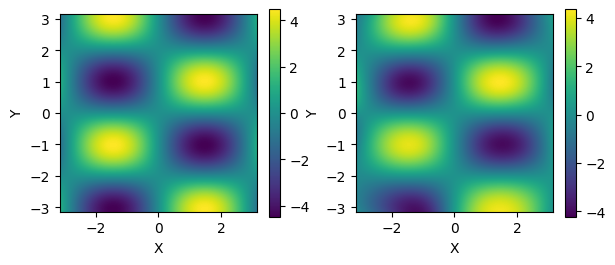

Epoch 200/2000
Data Loss: 0.05795527622103691, PDE Loss: 0.20122813433408737, Total Loss: 0.259183406829834, LR: 0.019510642410122164
Epoch 210/2000
Data Loss: 0.06260732933878899, PDE Loss: 0.19104070216417313, Total Loss: 0.2536480277776718, LR: 0.01946119629724703
Epoch 220/2000
Data Loss: 0.0451961737126112, PDE Loss: 0.19403641670942307, Total Loss: 0.2392325922846794, LR: 0.019409440449260143
Epoch 230/2000
Data Loss: 0.02987812552601099, PDE Loss: 0.11052440479397774, Total Loss: 0.14040252938866615, LR: 0.019355387636142543
Epoch 240/2000
Data Loss: 0.035339346155524254, PDE Loss: 0.12733256071805954, Total Loss: 0.16267190128564835, LR: 0.019299051194617067
Epoch 250/2000
Data Loss: 0.028950528241693974, PDE Loss: 0.15287911891937256, Total Loss: 0.18182964622974396, LR: 0.019240445024857673
Epoch 260/2000
Data Loss: 0.01642321888357401, PDE Loss: 0.07730621472001076, Total Loss: 0.09372943267226219, LR: 0.019179583587059814
Epoch 270/2000
Data Loss: 0.04224185645580292, PDE L

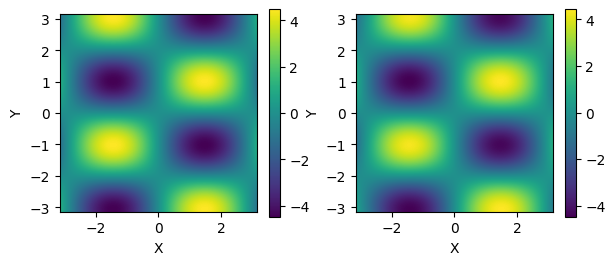

Epoch 500/2000
Data Loss: 0.005352937150746584, PDE Loss: 0.039488863199949265, Total Loss: 0.04484179988503456, LR: 0.017089352366654185
Epoch 510/2000
Data Loss: 0.010627140756696463, PDE Loss: 0.05718329735100269, Total Loss: 0.06781043857336044, LR: 0.016978360692740967
Epoch 520/2000
Data Loss: 0.006934566190466285, PDE Loss: 0.04284348897635937, Total Loss: 0.049778055399656296, LR: 0.016865671886249933
Epoch 530/2000
Data Loss: 0.0038290495285764337, PDE Loss: 0.018718107603490353, Total Loss: 0.022547156549990177, LR: 0.01675131375145789
Epoch 540/2000
Data Loss: 0.007290725829079747, PDE Loss: 0.04357678070664406, Total Loss: 0.05086750537157059, LR: 0.016635314504523418
Epoch 550/2000
Data Loss: 0.004155085887759924, PDE Loss: 0.03399949241429567, Total Loss: 0.038154578767716885, LR: 0.016517702766524964
Epoch 560/2000
Data Loss: 0.004944775020703673, PDE Loss: 0.04294302687048912, Total Loss: 0.04788780212402344, LR: 0.01639850755639902
Epoch 570/2000
Data Loss: 0.006438637

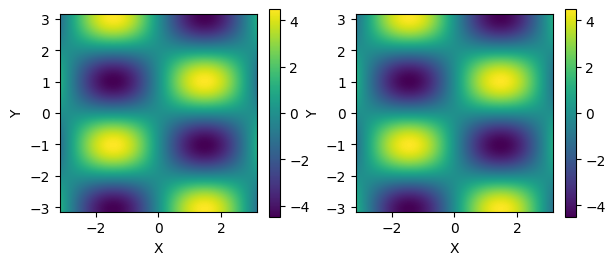

Epoch 1000/2000
Data Loss: 7.59833783376962e-05, PDE Loss: 0.0005897987866774201, Total Loss: 0.0006657821650151163, LR: 0.010084449122759775
Epoch 1010/2000
Data Loss: 4.48169230367057e-05, PDE Loss: 0.0003970681282225996, Total Loss: 0.0004418850439833477, LR: 0.009928948791689294
Epoch 1020/2000
Data Loss: 3.3804046324803494e-05, PDE Loss: 0.00033862600685097277, Total Loss: 0.00037243004771880805, LR: 0.009773490664944966
Epoch 1030/2000
Data Loss: 3.9840166209614836e-05, PDE Loss: 0.00033975216501858085, Total Loss: 0.0003795923257712275, LR: 0.009618113099493399
Epoch 1040/2000
Data Loss: 3.0289780625025742e-05, PDE Loss: 0.00029169043409638107, Total Loss: 0.0003219802165403962, LR: 0.009462854432423905
Epoch 1050/2000
Data Loss: 6.624380694120191e-05, PDE Loss: 0.0005586821062024683, Total Loss: 0.000624925916781649, LR: 0.009307752971489397
Epoch 1060/2000
Data Loss: 3.9623268094146624e-05, PDE Loss: 0.00035163405118510127, Total Loss: 0.0003912573301931843, LR: 0.009152846985

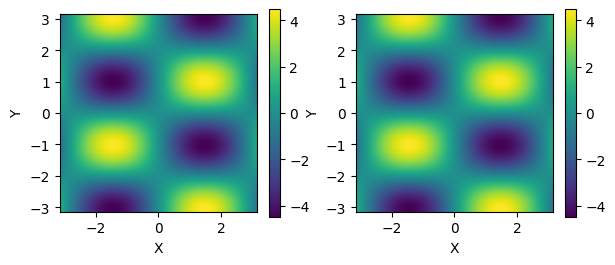

total loss :  0.00010467186439200304
DATA  loss :  1.3268598650029162e-05
PDE   loss :  9.140326437773183e-05


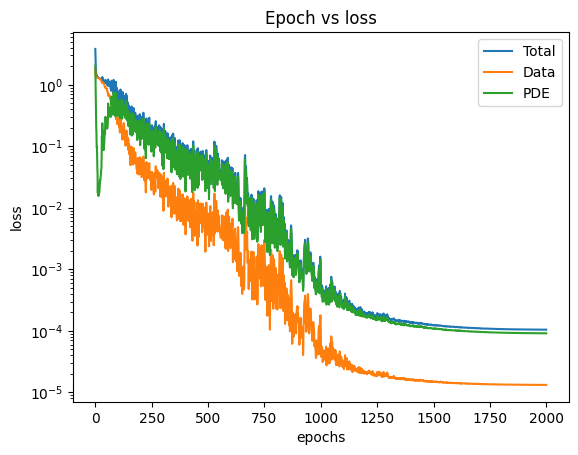

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Epoch 0/2000
Data Loss: 1.105243057012558, PDE Loss: 1.9610798358917236, Total Loss: 3.066322922706604, LR: 0.019999987786367066
Task :: A=2.777942819756045, B=1.7213625675027244, C=1.216882697534249
Test MSE Loss :  1.0882161096152092


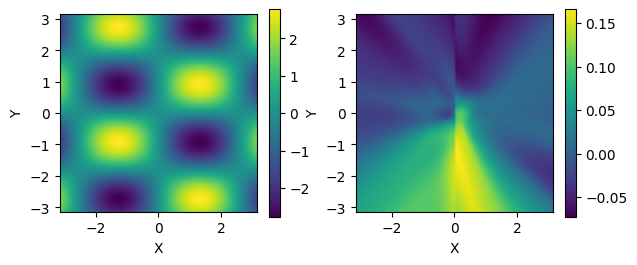

Epoch 10/2000
Data Loss: 0.6935677528381348, PDE Loss: 0.03313136100769043, Total Loss: 0.7266991138458252, LR: 0.019998522186878982
Epoch 20/2000
Data Loss: 0.6756828427314758, PDE Loss: 0.009168991353362799, Total Loss: 0.6848518252372742, LR: 0.01999461427515605
Epoch 30/2000
Data Loss: 0.6339842677116394, PDE Loss: 0.019557729363441467, Total Loss: 0.6535419821739197, LR: 0.01998826501541702
Epoch 40/2000
Data Loss: 0.558759868144989, PDE Loss: 0.07513697259128094, Total Loss: 0.6338968276977539, LR: 0.019979475974246718
Task :: A=2.777942819756045, B=1.7213625675027244, C=1.216882697534249
Test MSE Loss :  1.0596537072758603


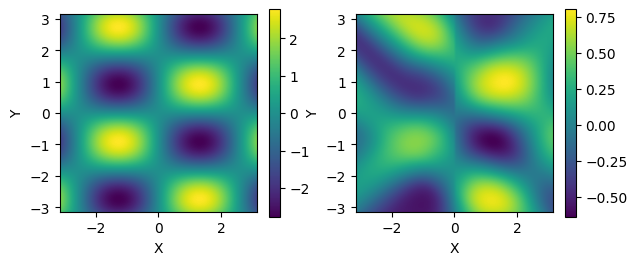

Epoch 50/2000
Data Loss: 0.4976828843355179, PDE Loss: 0.12719905376434326, Total Loss: 0.6248819231987, LR: 0.019968249320209543
Epoch 60/2000
Data Loss: 0.44628699123859406, PDE Loss: 0.14272645860910416, Total Loss: 0.5890134572982788, LR: 0.01995458782331439
Epoch 70/2000
Data Loss: 0.4005500376224518, PDE Loss: 0.11536817252635956, Total Loss: 0.5159181952476501, LR: 0.0199384948543312
Epoch 80/2000
Data Loss: 0.3550960421562195, PDE Loss: 0.19180796295404434, Total Loss: 0.5469039976596832, LR: 0.01991997438395926
Epoch 90/2000
Data Loss: 0.3001517504453659, PDE Loss: 0.17002037167549133, Total Loss: 0.47017212212085724, LR: 0.019899030981847508
Task :: A=2.777942819756045, B=1.7213625675027244, C=1.216882697534249
Test MSE Loss :  0.9596597109675055


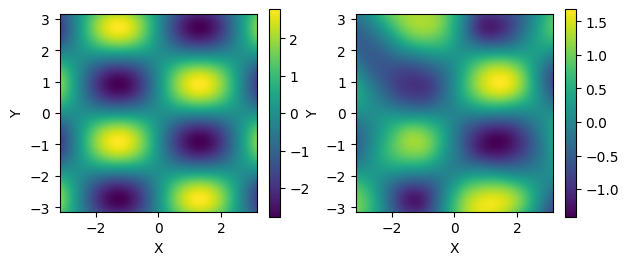

Epoch 100/2000
Data Loss: 0.290565550327301, PDE Loss: 0.22964774817228317, Total Loss: 0.5202133059501648, LR: 0.019875669815467036
Epoch 110/2000
Data Loss: 0.23151740431785583, PDE Loss: 0.2960089221596718, Total Loss: 0.5275263339281082, LR: 0.019849896648836084
Epoch 120/2000
Data Loss: 0.21058613806962967, PDE Loss: 0.16743642836809158, Total Loss: 0.37802256643772125, LR: 0.019821717841097868
Epoch 130/2000
Data Loss: 0.18926697969436646, PDE Loss: 0.18337751179933548, Total Loss: 0.37264449894428253, LR: 0.019791140344951545
Epoch 140/2000
Data Loss: 0.1342032365500927, PDE Loss: 0.2018168866634369, Total Loss: 0.3360201269388199, LR: 0.01975817170493675
Epoch 150/2000
Data Loss: 0.14904508739709854, PDE Loss: 0.19661564379930496, Total Loss: 0.3456607162952423, LR: 0.01972282005557209
Epoch 160/2000
Data Loss: 0.0949835255742073, PDE Loss: 0.1691705584526062, Total Loss: 0.2641540914773941, LR: 0.019685094119348066
Epoch 170/2000
Data Loss: 0.070058174431324, PDE Loss: 0.17099

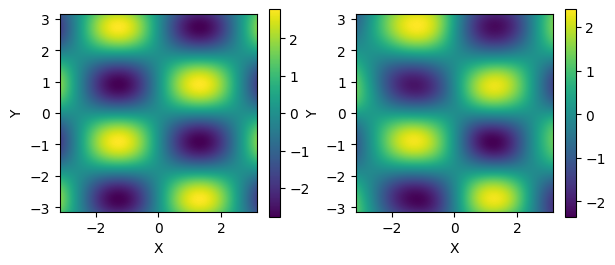

Epoch 200/2000
Data Loss: 0.04095720127224922, PDE Loss: 0.10058527439832687, Total Loss: 0.1415424793958664, LR: 0.019510642410122164
Epoch 210/2000
Data Loss: 0.04037611372768879, PDE Loss: 0.09478344768285751, Total Loss: 0.13515955954790115, LR: 0.01946119629724703
Epoch 220/2000
Data Loss: 0.03979958035051823, PDE Loss: 0.15151271224021912, Total Loss: 0.1913122981786728, LR: 0.019409440449260143
Epoch 230/2000
Data Loss: 0.04205138422548771, PDE Loss: 0.12264852225780487, Total Loss: 0.16469990462064743, LR: 0.019355387636142543
Epoch 240/2000
Data Loss: 0.02961793728172779, PDE Loss: 0.15336204320192337, Total Loss: 0.1829799860715866, LR: 0.019299051194617067
Epoch 250/2000
Data Loss: 0.024960173293948174, PDE Loss: 0.13658367469906807, Total Loss: 0.1615438498556614, LR: 0.019240445024857673
Epoch 260/2000
Data Loss: 0.020201758481562138, PDE Loss: 0.08262656629085541, Total Loss: 0.10282832384109497, LR: 0.019179583587059814
Epoch 270/2000
Data Loss: 0.01818355079740286, PDE 

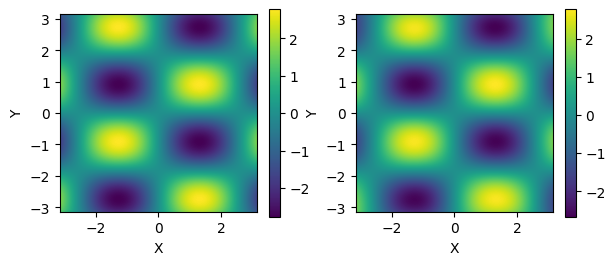

Epoch 500/2000
Data Loss: 0.0031197466887533665, PDE Loss: 0.02438916452229023, Total Loss: 0.027508911676704884, LR: 0.017089352366654185
Epoch 510/2000
Data Loss: 0.003257269039750099, PDE Loss: 0.02459903620183468, Total Loss: 0.027856305241584778, LR: 0.016978360692740967
Epoch 520/2000
Data Loss: 0.0024049283238127828, PDE Loss: 0.02242295630276203, Total Loss: 0.024827884510159492, LR: 0.016865671886249933
Epoch 530/2000
Data Loss: 0.0031283138087019324, PDE Loss: 0.025672649033367634, Total Loss: 0.028800963424146175, LR: 0.01675131375145789
Epoch 540/2000
Data Loss: 0.0021408547181636095, PDE Loss: 0.017858070321381092, Total Loss: 0.019998924806714058, LR: 0.016635314504523418
Epoch 550/2000
Data Loss: 0.0013915050658397377, PDE Loss: 0.010238668415695429, Total Loss: 0.011630173306912184, LR: 0.016517702766524964
Epoch 560/2000
Data Loss: 0.004063876229338348, PDE Loss: 0.030610639601945877, Total Loss: 0.03467451594769955, LR: 0.01639850755639902
Epoch 570/2000
Data Loss: 0.

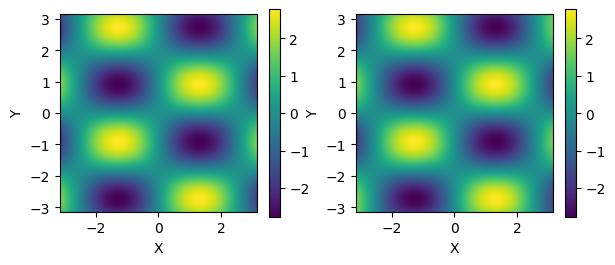

Epoch 1000/2000
Data Loss: 0.00014261075557442382, PDE Loss: 0.00034675539063755423, Total Loss: 0.0004893661534879357, LR: 0.010084449122759775
Epoch 1010/2000
Data Loss: 0.0001450576601200737, PDE Loss: 0.0004018691397504881, Total Loss: 0.000546926778042689, LR: 0.009928948791689294
Epoch 1020/2000
Data Loss: 0.00013292911899043247, PDE Loss: 0.0003020471049239859, Total Loss: 0.000434976231190376, LR: 0.009773490664944966
Epoch 1030/2000
Data Loss: 0.00014329085388453677, PDE Loss: 0.000417043745983392, Total Loss: 0.0005603345925919712, LR: 0.009618113099493399
Epoch 1040/2000
Data Loss: 0.00012774335482390597, PDE Loss: 0.00023260473972186446, Total Loss: 0.0003603480872698128, LR: 0.009462854432423905
Epoch 1050/2000
Data Loss: 0.00013001528714084998, PDE Loss: 0.00027263344964012504, Total Loss: 0.00040264874405693263, LR: 0.009307752971489397
Epoch 1060/2000
Data Loss: 0.00013038345787208527, PDE Loss: 0.0002974386588903144, Total Loss: 0.0004278221167623997, LR: 0.00915284698

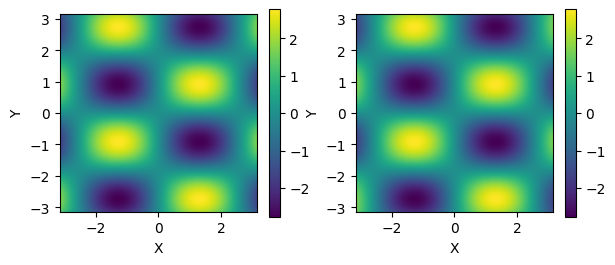

total loss :  0.00017329433467239141
DATA  loss :  8.32622499729041e-05
PDE   loss :  9.003209197544493e-05


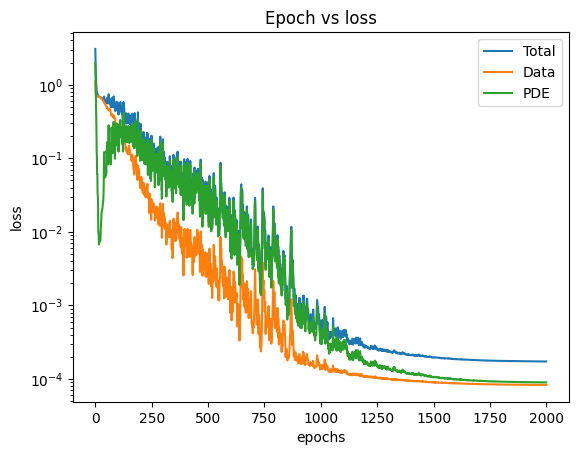

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Epoch 0/2000
Data Loss: 4.006900906562805, PDE Loss: 2.1105207353830338, Total Loss: 6.117421627044678, LR: 0.019999987786367066
Task :: A=9.374984508659168, B=0.6460623338874734, C=1.9654454951206688
Test MSE Loss :  4.286141860157195


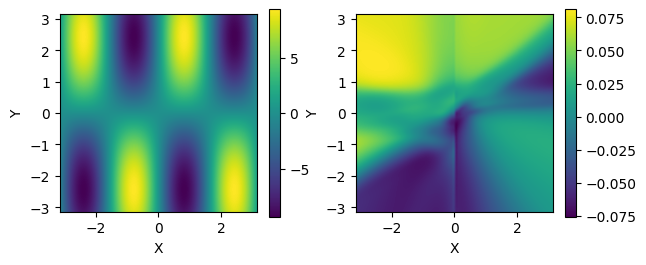

Epoch 10/2000
Data Loss: 3.8094749450683594, PDE Loss: 0.019373866729438305, Total Loss: 3.828848719596863, LR: 0.019998522186878982
Epoch 20/2000
Data Loss: 3.7556086778640747, PDE Loss: 0.02323277946561575, Total Loss: 3.778841495513916, LR: 0.01999461427515605
Epoch 30/2000
Data Loss: 3.649134874343872, PDE Loss: 0.10184591636061668, Total Loss: 3.750980854034424, LR: 0.01998826501541702
Epoch 40/2000
Data Loss: 3.4658424854278564, PDE Loss: 0.1572498008608818, Total Loss: 3.623092293739319, LR: 0.019979475974246718
Task :: A=9.374984508659168, B=0.6460623338874734, C=1.9654454951206688
Test MSE Loss :  4.261562105930765


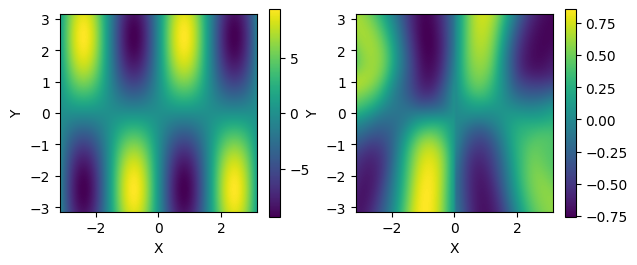

Epoch 50/2000
Data Loss: 3.4637941122055054, PDE Loss: 0.1732308343052864, Total Loss: 3.637024998664856, LR: 0.019968249320209543
Epoch 60/2000
Data Loss: 3.517325758934021, PDE Loss: 0.2590118870139122, Total Loss: 3.7763376235961914, LR: 0.01995458782331439
Epoch 70/2000
Data Loss: 3.4395025968551636, PDE Loss: 0.15474090725183487, Total Loss: 3.5942435264587402, LR: 0.0199384948543312
Epoch 80/2000
Data Loss: 3.261706233024597, PDE Loss: 0.36460599303245544, Total Loss: 3.6263121366500854, LR: 0.01991997438395926
Epoch 90/2000
Data Loss: 3.152360677719116, PDE Loss: 0.5052975416183472, Total Loss: 3.657658100128174, LR: 0.019899030981847508
Task :: A=9.374984508659168, B=0.6460623338874734, C=1.9654454951206688
Test MSE Loss :  4.109608498427299


KeyboardInterrupt: 

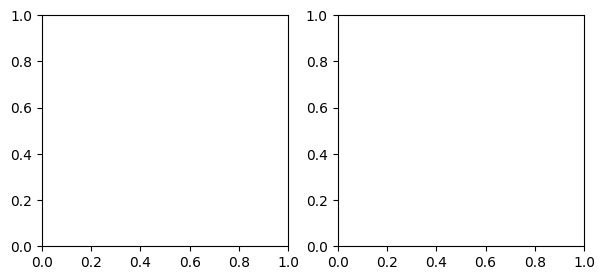

In [72]:
for inter_task in inter_tasks:
    print("-"*100)
    print("-"*100)
    model = MultiScaleMLPSequential(
        in_dim=2,
        out_dim=1,
        layers=7,
        neurons=32,
        residual=True,
        subnets=2,
        base_scale=1.1,
        in_scale= [2*np.pi,2*np.pi],
        in_center=[0, 0],
        vec_scen=2,
        vec_size=12,
    )
    model = model.to(device)
    # loss
    criterion = nn.SmoothL1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
    # scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=20, verbose=False)
    scheduler = CosineAnnealingWarmRestarts(optimizer, 2000, T_mult=1, eta_min=0.0002)

    # init
    loss_history = []
    data_loss_history = []
    pde_loss_history = []
    l1_loss_history = []

    best_loss = float('inf')
    transfer_model(model, inter_task, epochs, save_title="sketch")